In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from utilities import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gc
import itertools
%matplotlib inline

gc.enable()

train = pd.read_csv('training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']
train_det = train.where(train['detected'] == 1)

aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

aggs_det = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['mean', 'std', 'var'],
}

agg_train = train.groupby('object_id').agg(aggs)
agg_train_det = train_det.groupby('object_id').agg(aggs_det)

new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
new_columns_det = [
    k + '_' + agg for k in aggs_det.keys() for agg in aggs_det[k]
]

agg_train.columns = new_columns
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

agg_train_det.columns = new_columns_det
agg_train_det['mjd_diff'] = agg_train_det['mjd_max'] - agg_train_det['mjd_min']

agg_train_det.columns = agg_train_det.columns + "_det"

del agg_train_det['mjd_max_det'], agg_train_det['mjd_min_det']

agg_train = pd.concat([agg_train, agg_train_det], axis=1, join='inner')

del train, train_det, agg_train_det
gc.collect()

agg_train = agg_train.values

In [2]:
X_feats = pd.read_csv('training_set_metadata_head.csv')
X_feats = X_feats.iloc[:,np.array([7, 8, 9, 10])]
X_feats['distmod'].fillna(0, inplace=True)
X_feats = X_feats.values

X_period = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_period.csv', header=None).values
X_power = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_power.csv', header=None).values
X_range = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_range.csv', header=None).values
X_skew = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_skewness.csv', header=None).values

X_feats = np.concatenate((X_feats, X_period, X_power, X_range, X_skew, agg_train), axis = 1)

X_all, labels_all = read_data_all2(data_path="F:\\Documents\\Kaggle\\PLAsTiCC")
X_all_p, labels_all_p = read_data_all2_p(data_path="F:\\Documents\\Kaggle\\PLAsTiCC")

  0%|                                                    | 0/6 [00:00<?, ?it/s]F:\Documents\Kaggle\PLAsTiCC\utilities.py:222: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X[:,:,i_ch] = dat_.as_matrix()
  0%|                                                    | 0/6 [00:00<?, ?it/s]F:\Documents\Kaggle\PLAsTiCC\utilities.py:266: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X[:,:,i_ch] = dat_.as_matrix()
100%|████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]


In [3]:
# Normalize?
X_all[:,1:1999,:] = standardize_full(X_all[:,1:1999,:])
X_all_p = standardize_full(X_all_p)
X_feats = standardize_feats_full(X_feats)

In [4]:
X_train, X_test, labels_train, labels_test = train_test_split(X_all, labels_all,
                                                stratify = labels_all, random_state = 111, test_size = 0.2)

X_train_feats, X_test_feats, _ , _ = train_test_split(X_feats, labels_all,
                                                stratify = labels_all, random_state = 111, test_size = 0.2)

X_train_p, X_test_p, _ , _ = train_test_split(X_all_p, labels_all,
                                                stratify = labels_all, random_state = 111, test_size = 0.2)

X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 222, test_size = 0.2)

X_tr_f, X_vld_f, lab_tr_f, lab_vld_f = train_test_split(X_train_feats, labels_train, 
                                                stratify = labels_train, random_state = 222, test_size = 0.2)

X_tr_p, X_vld_p, lab_tr_p, lab_vld_p = train_test_split(X_train_p, labels_train, 
                                                stratify = labels_train, random_state = 222, test_size = 0.2)

X_tr_f

array([[-0.65604672, -0.51838063, -1.53349927, ...,  1.43768042,
         1.60602404,  1.3282128 ],
       [-0.65604672, -0.51838063, -1.53349927, ...,  0.17531013,
        -0.01337359, -0.62363898],
       [-0.65604672, -0.51838063, -1.53349927, ..., -0.02197492,
        -0.21165453,  1.61488196],
       ...,
       [ 4.07982946,  3.38275786,  0.92914195, ...,  0.67226942,
         0.55175057, -0.66359923],
       [ 0.30872651, -0.03760535,  0.7052746 , ...,  0.37909655,
         0.20699545, -0.71820108],
       [-0.65604672, -0.51838063, -1.53349927, ...,  1.00470792,
         0.98225836,  1.73802519]])

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

X_tr_f

array([[-0.65604672, -0.51838063, -1.53349927, ...,  1.43768042,
         1.60602404,  1.3282128 ],
       [-0.65604672, -0.51838063, -1.53349927, ...,  0.17531013,
        -0.01337359, -0.62363898],
       [-0.65604672, -0.51838063, -1.53349927, ..., -0.02197492,
        -0.21165453,  1.61488196],
       ...,
       [ 4.07982946,  3.38275786,  0.92914195, ...,  0.67226942,
         0.55175057, -0.66359923],
       [ 0.30872651, -0.03760535,  0.7052746 , ...,  0.37909655,
         0.20699545, -0.71820108],
       [-0.65604672, -0.51838063, -1.53349927, ...,  1.00470792,
         0.98225836,  1.73802519]])

In [6]:
# Imports
import tensorflow as tf

C:\Users\Ross\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
batch_size = 100       # Batch size
seq_len = 2000          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 14
n_channels = 6

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    inputs2_ = tf.placeholder(tf.float32, [None, 34], name = 'inputs2')
    inputs3_ = tf.placeholder(tf.float32, [None, seq_len/2, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [9]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=20, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=16, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=12, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=8, strides=2, padding='same')
    
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1_p = tf.layers.conv1d(inputs=inputs3_, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1_p = tf.layers.max_pooling1d(inputs=conv1_p, pool_size=10, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2_p = tf.layers.conv1d(inputs=max_pool_1_p, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2_p = tf.layers.max_pooling1d(inputs=conv2_p, pool_size=8, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3_p = tf.layers.conv1d(inputs=max_pool_2_p, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3_p = tf.layers.max_pooling1d(inputs=conv3_p, pool_size=6, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4_p = tf.layers.conv1d(inputs=max_pool_3_p, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4_p = tf.layers.max_pooling1d(inputs=conv4_p, pool_size=4, strides=2, padding='same')
    
print(max_pool_4.get_shape().as_list())
print(max_pool_4_p.get_shape().as_list())

[None, 8, 64]
[None, 4, 64]


In [10]:
with graph.as_default():
    # Flatten and add dropout
    nnfeats = tf.layers.dense(inputs=inputs2_, units=512, activation=tf.nn.tanh)
    nnfeats2 = tf.nn.dropout(nnfeats, keep_prob=keep_prob_)
    nnfeats3 = tf.layers.dense(inputs=nnfeats2, units=256, activation=tf.nn.tanh)
    nnfeats4 = tf.nn.dropout(nnfeats3, keep_prob=keep_prob_)
    nnfeats5 = tf.layers.dense(inputs=nnfeats4, units=128, activation=tf.nn.tanh)
    nnfeats6 = tf.nn.dropout(nnfeats5, keep_prob=keep_prob_)
    nnfeats7 = tf.layers.dense(inputs=nnfeats6, units=64, activation=tf.nn.tanh)
    nnfeats8 = tf.nn.dropout(nnfeats7, keep_prob=keep_prob_)
    
    flat = tf.concat([tf.reshape(max_pool_4, (-1, 8*64)), nnfeats8, tf.reshape(max_pool_4_p, (-1, 4*64))], 1)
    flat2 = tf.nn.dropout(flat, keep_prob=keep_prob_)
    flat3 = tf.layers.dense(inputs=flat2, units=512, activation=tf.nn.tanh)
    flat4 = tf.nn.dropout(flat3, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat4, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
print(flat.get_shape().as_list())

[None, 832]


In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y,x_f,x_p in get_batches(X_tr, y_tr, X_tr_f, X_tr_p, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, inputs2_ : x_f, inputs3_ : x_p, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v, x_v_f, x_v_p in get_batches(X_vld, y_vld, X_vld_f, X_vld_p, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, inputs2_ : x_v_f, inputs3_ : x_v_p, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 2.771522 Train acc: 0.060000
Epoch: 0/1000 Iteration: 10 Train loss: 2.796501 Train acc: 0.080000
Epoch: 0/1000 Iteration: 10 Validation loss: 2.539735 Validation acc: 0.142500
Epoch: 0/1000 Iteration: 15 Train loss: 2.660484 Train acc: 0.100000
Epoch: 0/1000 Iteration: 20 Train loss: 2.619295 Train acc: 0.140000
Epoch: 0/1000 Iteration: 20 Validation loss: 2.437320 Validation acc: 0.391667
Epoch: 0/1000 Iteration: 25 Train loss: 2.636302 Train acc: 0.170000
Epoch: 0/1000 Iteration: 30 Train loss: 2.512406 Train acc: 0.180000
Epoch: 0/1000 Iteration: 30 Validation loss: 2.348506 Validation acc: 0.498333
Epoch: 0/1000 Iteration: 35 Train loss: 2.589363 Train acc: 0.130000
Epoch: 0/1000 Iteration: 40 Train loss: 2.658084 Train acc: 0.140000
Epoch: 0/1000 Iteration: 40 Validation loss: 2.250958 Validation acc: 0.540833
Epoch: 0/1000 Iteration: 45 Train loss: 2.473369 Train acc: 0.210000
Epoch: 0/1000 Iteration: 50 Train loss: 2.416730 Train acc: 0.23

Epoch: 14/1000 Iteration: 745 Train loss: 1.272446 Train acc: 0.560000
Epoch: 14/1000 Iteration: 750 Train loss: 1.199589 Train acc: 0.610000
Epoch: 14/1000 Iteration: 750 Validation loss: 1.019472 Validation acc: 0.622500
Epoch: 15/1000 Iteration: 755 Train loss: 1.266272 Train acc: 0.570000
Epoch: 15/1000 Iteration: 760 Train loss: 1.167462 Train acc: 0.600000
Epoch: 15/1000 Iteration: 760 Validation loss: 1.024187 Validation acc: 0.628333
Epoch: 15/1000 Iteration: 765 Train loss: 1.058776 Train acc: 0.640000
Epoch: 15/1000 Iteration: 770 Train loss: 1.173996 Train acc: 0.630000
Epoch: 15/1000 Iteration: 770 Validation loss: 1.025893 Validation acc: 0.624167
Epoch: 15/1000 Iteration: 775 Train loss: 1.067399 Train acc: 0.660000
Epoch: 15/1000 Iteration: 780 Train loss: 1.230509 Train acc: 0.580000
Epoch: 15/1000 Iteration: 780 Validation loss: 1.026992 Validation acc: 0.624167
Epoch: 15/1000 Iteration: 785 Train loss: 1.088934 Train acc: 0.640000
Epoch: 15/1000 Iteration: 790 Train l

Epoch: 29/1000 Iteration: 1470 Train loss: 0.976835 Train acc: 0.680000
Epoch: 29/1000 Iteration: 1470 Validation loss: 0.929736 Validation acc: 0.677500
Epoch: 29/1000 Iteration: 1475 Train loss: 0.948503 Train acc: 0.670000
Epoch: 29/1000 Iteration: 1480 Train loss: 0.998335 Train acc: 0.610000
Epoch: 29/1000 Iteration: 1480 Validation loss: 0.909857 Validation acc: 0.684167
Epoch: 29/1000 Iteration: 1485 Train loss: 0.906716 Train acc: 0.670000
Epoch: 29/1000 Iteration: 1490 Train loss: 0.933169 Train acc: 0.730000
Epoch: 29/1000 Iteration: 1490 Validation loss: 0.914400 Validation acc: 0.684167
Epoch: 29/1000 Iteration: 1495 Train loss: 0.992091 Train acc: 0.670000
Epoch: 29/1000 Iteration: 1500 Train loss: 0.980748 Train acc: 0.670000
Epoch: 29/1000 Iteration: 1500 Validation loss: 0.912120 Validation acc: 0.685833
Epoch: 30/1000 Iteration: 1505 Train loss: 1.005327 Train acc: 0.620000
Epoch: 30/1000 Iteration: 1510 Train loss: 0.962554 Train acc: 0.690000
Epoch: 30/1000 Iteration

Epoch: 43/1000 Iteration: 2190 Train loss: 0.892767 Train acc: 0.730000
Epoch: 43/1000 Iteration: 2190 Validation loss: 0.850361 Validation acc: 0.710833
Epoch: 43/1000 Iteration: 2195 Train loss: 1.073534 Train acc: 0.620000
Epoch: 43/1000 Iteration: 2200 Train loss: 0.974376 Train acc: 0.690000
Epoch: 43/1000 Iteration: 2200 Validation loss: 0.852740 Validation acc: 0.717500
Epoch: 44/1000 Iteration: 2205 Train loss: 0.973637 Train acc: 0.640000
Epoch: 44/1000 Iteration: 2210 Train loss: 0.837355 Train acc: 0.740000
Epoch: 44/1000 Iteration: 2210 Validation loss: 0.846693 Validation acc: 0.718333
Epoch: 44/1000 Iteration: 2215 Train loss: 0.826208 Train acc: 0.720000
Epoch: 44/1000 Iteration: 2220 Train loss: 0.882802 Train acc: 0.670000
Epoch: 44/1000 Iteration: 2220 Validation loss: 0.862037 Validation acc: 0.708333
Epoch: 44/1000 Iteration: 2225 Train loss: 0.957145 Train acc: 0.660000
Epoch: 44/1000 Iteration: 2230 Train loss: 0.926847 Train acc: 0.650000
Epoch: 44/1000 Iteration

Epoch: 58/1000 Iteration: 2910 Train loss: 0.757186 Train acc: 0.780000
Epoch: 58/1000 Iteration: 2910 Validation loss: 0.803259 Validation acc: 0.733333
Epoch: 58/1000 Iteration: 2915 Train loss: 0.727986 Train acc: 0.760000
Epoch: 58/1000 Iteration: 2920 Train loss: 0.795993 Train acc: 0.770000
Epoch: 58/1000 Iteration: 2920 Validation loss: 0.821438 Validation acc: 0.719167
Epoch: 58/1000 Iteration: 2925 Train loss: 0.848844 Train acc: 0.730000
Epoch: 58/1000 Iteration: 2930 Train loss: 0.814147 Train acc: 0.730000
Epoch: 58/1000 Iteration: 2930 Validation loss: 0.807652 Validation acc: 0.725833
Epoch: 58/1000 Iteration: 2935 Train loss: 0.716615 Train acc: 0.730000
Epoch: 58/1000 Iteration: 2940 Train loss: 0.784466 Train acc: 0.760000
Epoch: 58/1000 Iteration: 2940 Validation loss: 0.814471 Validation acc: 0.724167
Epoch: 58/1000 Iteration: 2945 Train loss: 0.759693 Train acc: 0.730000
Epoch: 58/1000 Iteration: 2950 Train loss: 0.920471 Train acc: 0.680000
Epoch: 58/1000 Iteration

Epoch: 72/1000 Iteration: 3630 Train loss: 0.737448 Train acc: 0.770000
Epoch: 72/1000 Iteration: 3630 Validation loss: 0.773764 Validation acc: 0.747500
Epoch: 72/1000 Iteration: 3635 Train loss: 0.612293 Train acc: 0.770000
Epoch: 72/1000 Iteration: 3640 Train loss: 0.775357 Train acc: 0.760000
Epoch: 72/1000 Iteration: 3640 Validation loss: 0.811135 Validation acc: 0.732500
Epoch: 72/1000 Iteration: 3645 Train loss: 0.783317 Train acc: 0.700000
Epoch: 72/1000 Iteration: 3650 Train loss: 0.817423 Train acc: 0.700000
Epoch: 72/1000 Iteration: 3650 Validation loss: 0.772907 Validation acc: 0.747500
Epoch: 73/1000 Iteration: 3655 Train loss: 0.770895 Train acc: 0.740000
Epoch: 73/1000 Iteration: 3660 Train loss: 0.655215 Train acc: 0.790000
Epoch: 73/1000 Iteration: 3660 Validation loss: 0.777275 Validation acc: 0.740833
Epoch: 73/1000 Iteration: 3665 Train loss: 0.598583 Train acc: 0.790000
Epoch: 73/1000 Iteration: 3670 Train loss: 0.789843 Train acc: 0.780000
Epoch: 73/1000 Iteration

Epoch: 86/1000 Iteration: 4350 Train loss: 0.732866 Train acc: 0.760000
Epoch: 86/1000 Iteration: 4350 Validation loss: 0.772543 Validation acc: 0.750833
Epoch: 87/1000 Iteration: 4355 Train loss: 0.743843 Train acc: 0.730000
Epoch: 87/1000 Iteration: 4360 Train loss: 0.634782 Train acc: 0.800000
Epoch: 87/1000 Iteration: 4360 Validation loss: 0.767039 Validation acc: 0.747500
Epoch: 87/1000 Iteration: 4365 Train loss: 0.652550 Train acc: 0.790000
Epoch: 87/1000 Iteration: 4370 Train loss: 0.691657 Train acc: 0.780000
Epoch: 87/1000 Iteration: 4370 Validation loss: 0.777372 Validation acc: 0.745000
Epoch: 87/1000 Iteration: 4375 Train loss: 0.719054 Train acc: 0.770000
Epoch: 87/1000 Iteration: 4380 Train loss: 0.732889 Train acc: 0.730000
Epoch: 87/1000 Iteration: 4380 Validation loss: 0.765722 Validation acc: 0.748333
Epoch: 87/1000 Iteration: 4385 Train loss: 0.604545 Train acc: 0.750000
Epoch: 87/1000 Iteration: 4390 Train loss: 0.759704 Train acc: 0.730000
Epoch: 87/1000 Iteration

Epoch: 101/1000 Iteration: 5070 Train loss: 0.584834 Train acc: 0.790000
Epoch: 101/1000 Iteration: 5070 Validation loss: 0.761016 Validation acc: 0.753333
Epoch: 101/1000 Iteration: 5075 Train loss: 0.620983 Train acc: 0.800000
Epoch: 101/1000 Iteration: 5080 Train loss: 0.733708 Train acc: 0.740000
Epoch: 101/1000 Iteration: 5080 Validation loss: 0.748183 Validation acc: 0.755833
Epoch: 101/1000 Iteration: 5085 Train loss: 0.653458 Train acc: 0.760000
Epoch: 101/1000 Iteration: 5090 Train loss: 0.716358 Train acc: 0.780000
Epoch: 101/1000 Iteration: 5090 Validation loss: 0.752643 Validation acc: 0.760000
Epoch: 101/1000 Iteration: 5095 Train loss: 0.703311 Train acc: 0.730000
Epoch: 101/1000 Iteration: 5100 Train loss: 0.645491 Train acc: 0.800000
Epoch: 101/1000 Iteration: 5100 Validation loss: 0.760062 Validation acc: 0.760833
Epoch: 102/1000 Iteration: 5105 Train loss: 0.568298 Train acc: 0.780000
Epoch: 102/1000 Iteration: 5110 Train loss: 0.584465 Train acc: 0.780000
Epoch: 102/

Epoch: 115/1000 Iteration: 5780 Validation loss: 0.742367 Validation acc: 0.761667
Epoch: 115/1000 Iteration: 5785 Train loss: 0.608642 Train acc: 0.810000
Epoch: 115/1000 Iteration: 5790 Train loss: 0.640314 Train acc: 0.790000
Epoch: 115/1000 Iteration: 5790 Validation loss: 0.753566 Validation acc: 0.760000
Epoch: 115/1000 Iteration: 5795 Train loss: 0.557464 Train acc: 0.810000
Epoch: 115/1000 Iteration: 5800 Train loss: 0.591929 Train acc: 0.790000
Epoch: 115/1000 Iteration: 5800 Validation loss: 0.747396 Validation acc: 0.762500
Epoch: 116/1000 Iteration: 5805 Train loss: 0.642628 Train acc: 0.770000
Epoch: 116/1000 Iteration: 5810 Train loss: 0.584070 Train acc: 0.830000
Epoch: 116/1000 Iteration: 5810 Validation loss: 0.735916 Validation acc: 0.758333
Epoch: 116/1000 Iteration: 5815 Train loss: 0.526680 Train acc: 0.820000
Epoch: 116/1000 Iteration: 5820 Train loss: 0.533168 Train acc: 0.830000
Epoch: 116/1000 Iteration: 5820 Validation loss: 0.749499 Validation acc: 0.759167
E

Epoch: 129/1000 Iteration: 6495 Train loss: 0.559413 Train acc: 0.780000
Epoch: 129/1000 Iteration: 6500 Train loss: 0.708220 Train acc: 0.740000
Epoch: 129/1000 Iteration: 6500 Validation loss: 0.746725 Validation acc: 0.763333
Epoch: 130/1000 Iteration: 6505 Train loss: 0.573776 Train acc: 0.800000
Epoch: 130/1000 Iteration: 6510 Train loss: 0.499976 Train acc: 0.840000
Epoch: 130/1000 Iteration: 6510 Validation loss: 0.732897 Validation acc: 0.757500
Epoch: 130/1000 Iteration: 6515 Train loss: 0.519487 Train acc: 0.830000
Epoch: 130/1000 Iteration: 6520 Train loss: 0.584451 Train acc: 0.790000
Epoch: 130/1000 Iteration: 6520 Validation loss: 0.738116 Validation acc: 0.768333
Epoch: 130/1000 Iteration: 6525 Train loss: 0.545991 Train acc: 0.810000
Epoch: 130/1000 Iteration: 6530 Train loss: 0.703914 Train acc: 0.720000
Epoch: 130/1000 Iteration: 6530 Validation loss: 0.723941 Validation acc: 0.761667
Epoch: 130/1000 Iteration: 6535 Train loss: 0.593446 Train acc: 0.820000
Epoch: 130/

Epoch: 144/1000 Iteration: 7210 Train loss: 0.501006 Train acc: 0.830000
Epoch: 144/1000 Iteration: 7210 Validation loss: 0.752820 Validation acc: 0.760000
Epoch: 144/1000 Iteration: 7215 Train loss: 0.565621 Train acc: 0.800000
Epoch: 144/1000 Iteration: 7220 Train loss: 0.551089 Train acc: 0.840000
Epoch: 144/1000 Iteration: 7220 Validation loss: 0.755108 Validation acc: 0.769167
Epoch: 144/1000 Iteration: 7225 Train loss: 0.554765 Train acc: 0.780000
Epoch: 144/1000 Iteration: 7230 Train loss: 0.611870 Train acc: 0.770000
Epoch: 144/1000 Iteration: 7230 Validation loss: 0.733467 Validation acc: 0.765833
Epoch: 144/1000 Iteration: 7235 Train loss: 0.504230 Train acc: 0.850000
Epoch: 144/1000 Iteration: 7240 Train loss: 0.558151 Train acc: 0.830000
Epoch: 144/1000 Iteration: 7240 Validation loss: 0.748977 Validation acc: 0.771667
Epoch: 144/1000 Iteration: 7245 Train loss: 0.511171 Train acc: 0.840000
Epoch: 144/1000 Iteration: 7250 Train loss: 0.573497 Train acc: 0.810000
Epoch: 144/

Epoch: 158/1000 Iteration: 7920 Validation loss: 0.754744 Validation acc: 0.766667
Epoch: 158/1000 Iteration: 7925 Train loss: 0.499204 Train acc: 0.820000
Epoch: 158/1000 Iteration: 7930 Train loss: 0.633503 Train acc: 0.810000
Epoch: 158/1000 Iteration: 7930 Validation loss: 0.761100 Validation acc: 0.769167
Epoch: 158/1000 Iteration: 7935 Train loss: 0.461596 Train acc: 0.830000
Epoch: 158/1000 Iteration: 7940 Train loss: 0.593207 Train acc: 0.810000
Epoch: 158/1000 Iteration: 7940 Validation loss: 0.776284 Validation acc: 0.769167
Epoch: 158/1000 Iteration: 7945 Train loss: 0.521672 Train acc: 0.800000
Epoch: 158/1000 Iteration: 7950 Train loss: 0.599805 Train acc: 0.770000
Epoch: 158/1000 Iteration: 7950 Validation loss: 0.749612 Validation acc: 0.768333
Epoch: 159/1000 Iteration: 7955 Train loss: 0.490616 Train acc: 0.820000
Epoch: 159/1000 Iteration: 7960 Train loss: 0.481943 Train acc: 0.830000
Epoch: 159/1000 Iteration: 7960 Validation loss: 0.760874 Validation acc: 0.761667
E

Epoch: 172/1000 Iteration: 8635 Train loss: 0.532481 Train acc: 0.830000
Epoch: 172/1000 Iteration: 8640 Train loss: 0.568136 Train acc: 0.790000
Epoch: 172/1000 Iteration: 8640 Validation loss: 0.749133 Validation acc: 0.780833
Epoch: 172/1000 Iteration: 8645 Train loss: 0.481245 Train acc: 0.830000
Epoch: 172/1000 Iteration: 8650 Train loss: 0.494493 Train acc: 0.810000
Epoch: 172/1000 Iteration: 8650 Validation loss: 0.749715 Validation acc: 0.770000
Epoch: 173/1000 Iteration: 8655 Train loss: 0.512331 Train acc: 0.790000
Epoch: 173/1000 Iteration: 8660 Train loss: 0.497909 Train acc: 0.830000
Epoch: 173/1000 Iteration: 8660 Validation loss: 0.751473 Validation acc: 0.765833
Epoch: 173/1000 Iteration: 8665 Train loss: 0.531064 Train acc: 0.830000
Epoch: 173/1000 Iteration: 8670 Train loss: 0.520382 Train acc: 0.830000
Epoch: 173/1000 Iteration: 8670 Validation loss: 0.772574 Validation acc: 0.775000
Epoch: 173/1000 Iteration: 8675 Train loss: 0.473096 Train acc: 0.830000
Epoch: 173/

Epoch: 186/1000 Iteration: 9350 Train loss: 0.514577 Train acc: 0.800000
Epoch: 186/1000 Iteration: 9350 Validation loss: 0.770292 Validation acc: 0.770000
Epoch: 187/1000 Iteration: 9355 Train loss: 0.473637 Train acc: 0.800000
Epoch: 187/1000 Iteration: 9360 Train loss: 0.398488 Train acc: 0.880000
Epoch: 187/1000 Iteration: 9360 Validation loss: 0.762270 Validation acc: 0.765000
Epoch: 187/1000 Iteration: 9365 Train loss: 0.454840 Train acc: 0.870000
Epoch: 187/1000 Iteration: 9370 Train loss: 0.476938 Train acc: 0.860000
Epoch: 187/1000 Iteration: 9370 Validation loss: 0.773429 Validation acc: 0.776667
Epoch: 187/1000 Iteration: 9375 Train loss: 0.402695 Train acc: 0.870000
Epoch: 187/1000 Iteration: 9380 Train loss: 0.587757 Train acc: 0.810000
Epoch: 187/1000 Iteration: 9380 Validation loss: 0.763766 Validation acc: 0.771667
Epoch: 187/1000 Iteration: 9385 Train loss: 0.405952 Train acc: 0.850000
Epoch: 187/1000 Iteration: 9390 Train loss: 0.514077 Train acc: 0.840000
Epoch: 187/

Epoch: 201/1000 Iteration: 10060 Validation loss: 0.781687 Validation acc: 0.770000
Epoch: 201/1000 Iteration: 10065 Train loss: 0.485397 Train acc: 0.850000
Epoch: 201/1000 Iteration: 10070 Train loss: 0.398719 Train acc: 0.860000
Epoch: 201/1000 Iteration: 10070 Validation loss: 0.782657 Validation acc: 0.775833
Epoch: 201/1000 Iteration: 10075 Train loss: 0.437433 Train acc: 0.860000
Epoch: 201/1000 Iteration: 10080 Train loss: 0.483463 Train acc: 0.840000
Epoch: 201/1000 Iteration: 10080 Validation loss: 0.777857 Validation acc: 0.768333
Epoch: 201/1000 Iteration: 10085 Train loss: 0.357431 Train acc: 0.890000
Epoch: 201/1000 Iteration: 10090 Train loss: 0.430927 Train acc: 0.860000
Epoch: 201/1000 Iteration: 10090 Validation loss: 0.784123 Validation acc: 0.773333
Epoch: 201/1000 Iteration: 10095 Train loss: 0.454151 Train acc: 0.850000
Epoch: 201/1000 Iteration: 10100 Train loss: 0.437842 Train acc: 0.860000
Epoch: 201/1000 Iteration: 10100 Validation loss: 0.790644 Validation ac

Epoch: 215/1000 Iteration: 10760 Validation loss: 0.810770 Validation acc: 0.765000
Epoch: 215/1000 Iteration: 10765 Train loss: 0.453847 Train acc: 0.850000
Epoch: 215/1000 Iteration: 10770 Train loss: 0.474688 Train acc: 0.850000
Epoch: 215/1000 Iteration: 10770 Validation loss: 0.799795 Validation acc: 0.776667
Epoch: 215/1000 Iteration: 10775 Train loss: 0.448186 Train acc: 0.850000
Epoch: 215/1000 Iteration: 10780 Train loss: 0.425782 Train acc: 0.860000
Epoch: 215/1000 Iteration: 10780 Validation loss: 0.779845 Validation acc: 0.775833
Epoch: 215/1000 Iteration: 10785 Train loss: 0.423404 Train acc: 0.860000
Epoch: 215/1000 Iteration: 10790 Train loss: 0.491076 Train acc: 0.810000
Epoch: 215/1000 Iteration: 10790 Validation loss: 0.796932 Validation acc: 0.775000
Epoch: 215/1000 Iteration: 10795 Train loss: 0.384647 Train acc: 0.870000
Epoch: 215/1000 Iteration: 10800 Train loss: 0.469418 Train acc: 0.830000
Epoch: 215/1000 Iteration: 10800 Validation loss: 0.791132 Validation ac

Epoch: 229/1000 Iteration: 11460 Validation loss: 0.820984 Validation acc: 0.764167
Epoch: 229/1000 Iteration: 11465 Train loss: 0.431261 Train acc: 0.850000
Epoch: 229/1000 Iteration: 11470 Train loss: 0.438565 Train acc: 0.870000
Epoch: 229/1000 Iteration: 11470 Validation loss: 0.835836 Validation acc: 0.772500
Epoch: 229/1000 Iteration: 11475 Train loss: 0.339444 Train acc: 0.840000
Epoch: 229/1000 Iteration: 11480 Train loss: 0.450768 Train acc: 0.870000
Epoch: 229/1000 Iteration: 11480 Validation loss: 0.811382 Validation acc: 0.773333
Epoch: 229/1000 Iteration: 11485 Train loss: 0.439112 Train acc: 0.830000
Epoch: 229/1000 Iteration: 11490 Train loss: 0.380605 Train acc: 0.840000
Epoch: 229/1000 Iteration: 11490 Validation loss: 0.835025 Validation acc: 0.780833
Epoch: 229/1000 Iteration: 11495 Train loss: 0.378270 Train acc: 0.870000
Epoch: 229/1000 Iteration: 11500 Train loss: 0.460002 Train acc: 0.870000
Epoch: 229/1000 Iteration: 11500 Validation loss: 0.823776 Validation ac

Epoch: 243/1000 Iteration: 12160 Validation loss: 0.824072 Validation acc: 0.760833
Epoch: 243/1000 Iteration: 12165 Train loss: 0.419740 Train acc: 0.870000
Epoch: 243/1000 Iteration: 12170 Train loss: 0.433131 Train acc: 0.850000
Epoch: 243/1000 Iteration: 12170 Validation loss: 0.837136 Validation acc: 0.775833
Epoch: 243/1000 Iteration: 12175 Train loss: 0.351353 Train acc: 0.900000
Epoch: 243/1000 Iteration: 12180 Train loss: 0.520741 Train acc: 0.820000
Epoch: 243/1000 Iteration: 12180 Validation loss: 0.817300 Validation acc: 0.776667
Epoch: 243/1000 Iteration: 12185 Train loss: 0.331257 Train acc: 0.870000
Epoch: 243/1000 Iteration: 12190 Train loss: 0.325685 Train acc: 0.890000
Epoch: 243/1000 Iteration: 12190 Validation loss: 0.824009 Validation acc: 0.775833
Epoch: 243/1000 Iteration: 12195 Train loss: 0.329697 Train acc: 0.870000
Epoch: 243/1000 Iteration: 12200 Train loss: 0.388582 Train acc: 0.850000
Epoch: 243/1000 Iteration: 12200 Validation loss: 0.834480 Validation ac

Epoch: 257/1000 Iteration: 12860 Validation loss: 0.840926 Validation acc: 0.765833
Epoch: 257/1000 Iteration: 12865 Train loss: 0.428105 Train acc: 0.850000
Epoch: 257/1000 Iteration: 12870 Train loss: 0.339156 Train acc: 0.890000
Epoch: 257/1000 Iteration: 12870 Validation loss: 0.835055 Validation acc: 0.777500
Epoch: 257/1000 Iteration: 12875 Train loss: 0.380973 Train acc: 0.850000
Epoch: 257/1000 Iteration: 12880 Train loss: 0.404295 Train acc: 0.850000
Epoch: 257/1000 Iteration: 12880 Validation loss: 0.821875 Validation acc: 0.775833
Epoch: 257/1000 Iteration: 12885 Train loss: 0.368927 Train acc: 0.870000
Epoch: 257/1000 Iteration: 12890 Train loss: 0.310495 Train acc: 0.890000
Epoch: 257/1000 Iteration: 12890 Validation loss: 0.827040 Validation acc: 0.781667
Epoch: 257/1000 Iteration: 12895 Train loss: 0.350604 Train acc: 0.860000
Epoch: 257/1000 Iteration: 12900 Train loss: 0.348393 Train acc: 0.850000
Epoch: 257/1000 Iteration: 12900 Validation loss: 0.838780 Validation ac

Epoch: 271/1000 Iteration: 13560 Validation loss: 0.851227 Validation acc: 0.772500
Epoch: 271/1000 Iteration: 13565 Train loss: 0.476072 Train acc: 0.840000
Epoch: 271/1000 Iteration: 13570 Train loss: 0.333178 Train acc: 0.870000
Epoch: 271/1000 Iteration: 13570 Validation loss: 0.867969 Validation acc: 0.772500
Epoch: 271/1000 Iteration: 13575 Train loss: 0.359173 Train acc: 0.860000
Epoch: 271/1000 Iteration: 13580 Train loss: 0.361380 Train acc: 0.910000
Epoch: 271/1000 Iteration: 13580 Validation loss: 0.837836 Validation acc: 0.771667
Epoch: 271/1000 Iteration: 13585 Train loss: 0.314704 Train acc: 0.870000
Epoch: 271/1000 Iteration: 13590 Train loss: 0.303035 Train acc: 0.860000
Epoch: 271/1000 Iteration: 13590 Validation loss: 0.848271 Validation acc: 0.775833
Epoch: 271/1000 Iteration: 13595 Train loss: 0.268002 Train acc: 0.910000
Epoch: 271/1000 Iteration: 13600 Train loss: 0.312763 Train acc: 0.890000
Epoch: 271/1000 Iteration: 13600 Validation loss: 0.863142 Validation ac

Epoch: 285/1000 Iteration: 14260 Validation loss: 0.883539 Validation acc: 0.757500
Epoch: 285/1000 Iteration: 14265 Train loss: 0.358480 Train acc: 0.890000
Epoch: 285/1000 Iteration: 14270 Train loss: 0.319076 Train acc: 0.880000
Epoch: 285/1000 Iteration: 14270 Validation loss: 0.926289 Validation acc: 0.767500
Epoch: 285/1000 Iteration: 14275 Train loss: 0.285579 Train acc: 0.930000
Epoch: 285/1000 Iteration: 14280 Train loss: 0.406986 Train acc: 0.880000
Epoch: 285/1000 Iteration: 14280 Validation loss: 0.870584 Validation acc: 0.768333
Epoch: 285/1000 Iteration: 14285 Train loss: 0.268820 Train acc: 0.880000
Epoch: 285/1000 Iteration: 14290 Train loss: 0.332025 Train acc: 0.880000
Epoch: 285/1000 Iteration: 14290 Validation loss: 0.906725 Validation acc: 0.770833
Epoch: 285/1000 Iteration: 14295 Train loss: 0.361926 Train acc: 0.860000
Epoch: 285/1000 Iteration: 14300 Train loss: 0.337219 Train acc: 0.870000
Epoch: 285/1000 Iteration: 14300 Validation loss: 0.899804 Validation ac

Epoch: 299/1000 Iteration: 14960 Validation loss: 0.887293 Validation acc: 0.765833
Epoch: 299/1000 Iteration: 14965 Train loss: 0.411814 Train acc: 0.850000
Epoch: 299/1000 Iteration: 14970 Train loss: 0.291141 Train acc: 0.890000
Epoch: 299/1000 Iteration: 14970 Validation loss: 0.930488 Validation acc: 0.770000
Epoch: 299/1000 Iteration: 14975 Train loss: 0.275495 Train acc: 0.910000
Epoch: 299/1000 Iteration: 14980 Train loss: 0.390434 Train acc: 0.840000
Epoch: 299/1000 Iteration: 14980 Validation loss: 0.898024 Validation acc: 0.765833
Epoch: 299/1000 Iteration: 14985 Train loss: 0.331004 Train acc: 0.880000
Epoch: 299/1000 Iteration: 14990 Train loss: 0.286838 Train acc: 0.880000
Epoch: 299/1000 Iteration: 14990 Validation loss: 0.919177 Validation acc: 0.775833
Epoch: 299/1000 Iteration: 14995 Train loss: 0.274908 Train acc: 0.910000
Epoch: 299/1000 Iteration: 15000 Train loss: 0.302669 Train acc: 0.900000
Epoch: 299/1000 Iteration: 15000 Validation loss: 0.948712 Validation ac

Epoch: 313/1000 Iteration: 15660 Validation loss: 0.920724 Validation acc: 0.774167
Epoch: 313/1000 Iteration: 15665 Train loss: 0.325218 Train acc: 0.880000
Epoch: 313/1000 Iteration: 15670 Train loss: 0.269853 Train acc: 0.910000
Epoch: 313/1000 Iteration: 15670 Validation loss: 0.967529 Validation acc: 0.766667
Epoch: 313/1000 Iteration: 15675 Train loss: 0.257490 Train acc: 0.920000
Epoch: 313/1000 Iteration: 15680 Train loss: 0.293471 Train acc: 0.900000
Epoch: 313/1000 Iteration: 15680 Validation loss: 0.903507 Validation acc: 0.774167
Epoch: 313/1000 Iteration: 15685 Train loss: 0.256574 Train acc: 0.890000
Epoch: 313/1000 Iteration: 15690 Train loss: 0.245452 Train acc: 0.910000
Epoch: 313/1000 Iteration: 15690 Validation loss: 0.929461 Validation acc: 0.778333
Epoch: 313/1000 Iteration: 15695 Train loss: 0.279824 Train acc: 0.920000
Epoch: 313/1000 Iteration: 15700 Train loss: 0.304299 Train acc: 0.860000
Epoch: 313/1000 Iteration: 15700 Validation loss: 0.941322 Validation ac

Epoch: 327/1000 Iteration: 16360 Validation loss: 0.959469 Validation acc: 0.755000
Epoch: 327/1000 Iteration: 16365 Train loss: 0.296432 Train acc: 0.900000
Epoch: 327/1000 Iteration: 16370 Train loss: 0.256181 Train acc: 0.920000
Epoch: 327/1000 Iteration: 16370 Validation loss: 0.997659 Validation acc: 0.766667
Epoch: 327/1000 Iteration: 16375 Train loss: 0.290224 Train acc: 0.920000
Epoch: 327/1000 Iteration: 16380 Train loss: 0.350980 Train acc: 0.870000
Epoch: 327/1000 Iteration: 16380 Validation loss: 0.932983 Validation acc: 0.761667
Epoch: 327/1000 Iteration: 16385 Train loss: 0.223113 Train acc: 0.920000
Epoch: 327/1000 Iteration: 16390 Train loss: 0.209251 Train acc: 0.950000
Epoch: 327/1000 Iteration: 16390 Validation loss: 0.948170 Validation acc: 0.767500
Epoch: 327/1000 Iteration: 16395 Train loss: 0.281497 Train acc: 0.900000
Epoch: 327/1000 Iteration: 16400 Train loss: 0.278460 Train acc: 0.900000
Epoch: 327/1000 Iteration: 16400 Validation loss: 0.971796 Validation ac

Epoch: 341/1000 Iteration: 17060 Validation loss: 0.972322 Validation acc: 0.758333
Epoch: 341/1000 Iteration: 17065 Train loss: 0.264728 Train acc: 0.920000
Epoch: 341/1000 Iteration: 17070 Train loss: 0.203473 Train acc: 0.900000
Epoch: 341/1000 Iteration: 17070 Validation loss: 1.015889 Validation acc: 0.779167
Epoch: 341/1000 Iteration: 17075 Train loss: 0.224627 Train acc: 0.910000
Epoch: 341/1000 Iteration: 17080 Train loss: 0.229105 Train acc: 0.960000
Epoch: 341/1000 Iteration: 17080 Validation loss: 0.958158 Validation acc: 0.769167
Epoch: 341/1000 Iteration: 17085 Train loss: 0.245503 Train acc: 0.910000
Epoch: 341/1000 Iteration: 17090 Train loss: 0.186679 Train acc: 0.940000
Epoch: 341/1000 Iteration: 17090 Validation loss: 0.993009 Validation acc: 0.773333
Epoch: 341/1000 Iteration: 17095 Train loss: 0.341187 Train acc: 0.890000
Epoch: 341/1000 Iteration: 17100 Train loss: 0.205699 Train acc: 0.950000
Epoch: 341/1000 Iteration: 17100 Validation loss: 0.964768 Validation ac

Epoch: 355/1000 Iteration: 17760 Validation loss: 1.019692 Validation acc: 0.764167
Epoch: 355/1000 Iteration: 17765 Train loss: 0.309087 Train acc: 0.900000
Epoch: 355/1000 Iteration: 17770 Train loss: 0.284774 Train acc: 0.900000
Epoch: 355/1000 Iteration: 17770 Validation loss: 1.068174 Validation acc: 0.763333
Epoch: 355/1000 Iteration: 17775 Train loss: 0.296199 Train acc: 0.880000
Epoch: 355/1000 Iteration: 17780 Train loss: 0.250064 Train acc: 0.910000
Epoch: 355/1000 Iteration: 17780 Validation loss: 1.015474 Validation acc: 0.772500
Epoch: 355/1000 Iteration: 17785 Train loss: 0.199475 Train acc: 0.940000
Epoch: 355/1000 Iteration: 17790 Train loss: 0.246897 Train acc: 0.940000
Epoch: 355/1000 Iteration: 17790 Validation loss: 1.043046 Validation acc: 0.768333
Epoch: 355/1000 Iteration: 17795 Train loss: 0.194649 Train acc: 0.940000
Epoch: 355/1000 Iteration: 17800 Train loss: 0.165689 Train acc: 0.940000
Epoch: 355/1000 Iteration: 17800 Validation loss: 1.019624 Validation ac

Epoch: 369/1000 Iteration: 18460 Validation loss: 1.021635 Validation acc: 0.765000
Epoch: 369/1000 Iteration: 18465 Train loss: 0.214530 Train acc: 0.920000
Epoch: 369/1000 Iteration: 18470 Train loss: 0.184903 Train acc: 0.950000
Epoch: 369/1000 Iteration: 18470 Validation loss: 1.078842 Validation acc: 0.769167
Epoch: 369/1000 Iteration: 18475 Train loss: 0.240509 Train acc: 0.920000
Epoch: 369/1000 Iteration: 18480 Train loss: 0.328060 Train acc: 0.900000
Epoch: 369/1000 Iteration: 18480 Validation loss: 1.023301 Validation acc: 0.760000
Epoch: 369/1000 Iteration: 18485 Train loss: 0.261919 Train acc: 0.900000
Epoch: 369/1000 Iteration: 18490 Train loss: 0.153922 Train acc: 0.950000
Epoch: 369/1000 Iteration: 18490 Validation loss: 1.059337 Validation acc: 0.770000
Epoch: 369/1000 Iteration: 18495 Train loss: 0.258530 Train acc: 0.890000
Epoch: 369/1000 Iteration: 18500 Train loss: 0.228149 Train acc: 0.920000
Epoch: 369/1000 Iteration: 18500 Validation loss: 1.046797 Validation ac

Epoch: 383/1000 Iteration: 19160 Validation loss: 1.075950 Validation acc: 0.769167
Epoch: 383/1000 Iteration: 19165 Train loss: 0.215756 Train acc: 0.910000
Epoch: 383/1000 Iteration: 19170 Train loss: 0.203500 Train acc: 0.920000
Epoch: 383/1000 Iteration: 19170 Validation loss: 1.058216 Validation acc: 0.764167
Epoch: 383/1000 Iteration: 19175 Train loss: 0.251036 Train acc: 0.900000
Epoch: 383/1000 Iteration: 19180 Train loss: 0.196410 Train acc: 0.930000
Epoch: 383/1000 Iteration: 19180 Validation loss: 1.017746 Validation acc: 0.767500
Epoch: 383/1000 Iteration: 19185 Train loss: 0.168678 Train acc: 0.960000
Epoch: 383/1000 Iteration: 19190 Train loss: 0.144003 Train acc: 0.970000
Epoch: 383/1000 Iteration: 19190 Validation loss: 1.076524 Validation acc: 0.771667
Epoch: 383/1000 Iteration: 19195 Train loss: 0.241139 Train acc: 0.890000
Epoch: 383/1000 Iteration: 19200 Train loss: 0.192995 Train acc: 0.940000
Epoch: 383/1000 Iteration: 19200 Validation loss: 1.061686 Validation ac

Epoch: 397/1000 Iteration: 19860 Validation loss: 1.098206 Validation acc: 0.767500
Epoch: 397/1000 Iteration: 19865 Train loss: 0.203917 Train acc: 0.910000
Epoch: 397/1000 Iteration: 19870 Train loss: 0.218748 Train acc: 0.920000
Epoch: 397/1000 Iteration: 19870 Validation loss: 1.102824 Validation acc: 0.768333
Epoch: 397/1000 Iteration: 19875 Train loss: 0.223448 Train acc: 0.940000
Epoch: 397/1000 Iteration: 19880 Train loss: 0.167638 Train acc: 0.950000
Epoch: 397/1000 Iteration: 19880 Validation loss: 1.052686 Validation acc: 0.767500
Epoch: 397/1000 Iteration: 19885 Train loss: 0.227871 Train acc: 0.910000
Epoch: 397/1000 Iteration: 19890 Train loss: 0.154405 Train acc: 0.950000
Epoch: 397/1000 Iteration: 19890 Validation loss: 1.081295 Validation acc: 0.770833
Epoch: 397/1000 Iteration: 19895 Train loss: 0.288677 Train acc: 0.880000
Epoch: 397/1000 Iteration: 19900 Train loss: 0.201898 Train acc: 0.940000
Epoch: 397/1000 Iteration: 19900 Validation loss: 1.054335 Validation ac

Epoch: 411/1000 Iteration: 20560 Validation loss: 1.223015 Validation acc: 0.761667
Epoch: 411/1000 Iteration: 20565 Train loss: 0.166833 Train acc: 0.940000
Epoch: 411/1000 Iteration: 20570 Train loss: 0.164764 Train acc: 0.940000
Epoch: 411/1000 Iteration: 20570 Validation loss: 1.160479 Validation acc: 0.764167
Epoch: 411/1000 Iteration: 20575 Train loss: 0.187354 Train acc: 0.950000
Epoch: 411/1000 Iteration: 20580 Train loss: 0.240330 Train acc: 0.930000
Epoch: 411/1000 Iteration: 20580 Validation loss: 1.089000 Validation acc: 0.765833
Epoch: 411/1000 Iteration: 20585 Train loss: 0.163889 Train acc: 0.940000
Epoch: 411/1000 Iteration: 20590 Train loss: 0.139544 Train acc: 0.960000
Epoch: 411/1000 Iteration: 20590 Validation loss: 1.111914 Validation acc: 0.770833
Epoch: 411/1000 Iteration: 20595 Train loss: 0.182207 Train acc: 0.930000
Epoch: 411/1000 Iteration: 20600 Train loss: 0.140808 Train acc: 0.970000
Epoch: 411/1000 Iteration: 20600 Validation loss: 1.112470 Validation ac

Epoch: 425/1000 Iteration: 21260 Validation loss: 1.110513 Validation acc: 0.776667
Epoch: 425/1000 Iteration: 21265 Train loss: 0.183882 Train acc: 0.920000
Epoch: 425/1000 Iteration: 21270 Train loss: 0.124839 Train acc: 0.970000
Epoch: 425/1000 Iteration: 21270 Validation loss: 1.196215 Validation acc: 0.772500
Epoch: 425/1000 Iteration: 21275 Train loss: 0.181021 Train acc: 0.950000
Epoch: 425/1000 Iteration: 21280 Train loss: 0.189412 Train acc: 0.960000
Epoch: 425/1000 Iteration: 21280 Validation loss: 1.143279 Validation acc: 0.783333
Epoch: 425/1000 Iteration: 21285 Train loss: 0.208985 Train acc: 0.920000
Epoch: 425/1000 Iteration: 21290 Train loss: 0.202960 Train acc: 0.910000
Epoch: 425/1000 Iteration: 21290 Validation loss: 1.106441 Validation acc: 0.760833
Epoch: 425/1000 Iteration: 21295 Train loss: 0.238384 Train acc: 0.930000
Epoch: 425/1000 Iteration: 21300 Train loss: 0.138894 Train acc: 0.940000
Epoch: 425/1000 Iteration: 21300 Validation loss: 1.118729 Validation ac

Epoch: 439/1000 Iteration: 21960 Validation loss: 1.247861 Validation acc: 0.770833
Epoch: 439/1000 Iteration: 21965 Train loss: 0.173383 Train acc: 0.950000
Epoch: 439/1000 Iteration: 21970 Train loss: 0.139288 Train acc: 0.940000
Epoch: 439/1000 Iteration: 21970 Validation loss: 1.213668 Validation acc: 0.779167
Epoch: 439/1000 Iteration: 21975 Train loss: 0.114742 Train acc: 0.980000
Epoch: 439/1000 Iteration: 21980 Train loss: 0.255938 Train acc: 0.910000
Epoch: 439/1000 Iteration: 21980 Validation loss: 1.148536 Validation acc: 0.775833
Epoch: 439/1000 Iteration: 21985 Train loss: 0.128791 Train acc: 0.970000
Epoch: 439/1000 Iteration: 21990 Train loss: 0.170464 Train acc: 0.930000
Epoch: 439/1000 Iteration: 21990 Validation loss: 1.159541 Validation acc: 0.775000
Epoch: 439/1000 Iteration: 21995 Train loss: 0.134010 Train acc: 0.940000
Epoch: 439/1000 Iteration: 22000 Train loss: 0.141713 Train acc: 0.950000
Epoch: 439/1000 Iteration: 22000 Validation loss: 1.181181 Validation ac

Epoch: 453/1000 Iteration: 22660 Validation loss: 1.217902 Validation acc: 0.768333
Epoch: 453/1000 Iteration: 22665 Train loss: 0.137727 Train acc: 0.950000
Epoch: 453/1000 Iteration: 22670 Train loss: 0.179043 Train acc: 0.930000
Epoch: 453/1000 Iteration: 22670 Validation loss: 1.246542 Validation acc: 0.762500
Epoch: 453/1000 Iteration: 22675 Train loss: 0.147107 Train acc: 0.940000
Epoch: 453/1000 Iteration: 22680 Train loss: 0.177091 Train acc: 0.930000
Epoch: 453/1000 Iteration: 22680 Validation loss: 1.180469 Validation acc: 0.770000
Epoch: 453/1000 Iteration: 22685 Train loss: 0.213078 Train acc: 0.910000
Epoch: 453/1000 Iteration: 22690 Train loss: 0.105124 Train acc: 0.980000
Epoch: 453/1000 Iteration: 22690 Validation loss: 1.159051 Validation acc: 0.765833
Epoch: 453/1000 Iteration: 22695 Train loss: 0.107501 Train acc: 0.960000
Epoch: 453/1000 Iteration: 22700 Train loss: 0.178207 Train acc: 0.930000
Epoch: 453/1000 Iteration: 22700 Validation loss: 1.184192 Validation ac

Epoch: 467/1000 Iteration: 23360 Validation loss: 1.287120 Validation acc: 0.765833
Epoch: 467/1000 Iteration: 23365 Train loss: 0.169097 Train acc: 0.920000
Epoch: 467/1000 Iteration: 23370 Train loss: 0.139146 Train acc: 0.960000
Epoch: 467/1000 Iteration: 23370 Validation loss: 1.285618 Validation acc: 0.769167
Epoch: 467/1000 Iteration: 23375 Train loss: 0.135307 Train acc: 0.950000
Epoch: 467/1000 Iteration: 23380 Train loss: 0.192692 Train acc: 0.950000
Epoch: 467/1000 Iteration: 23380 Validation loss: 1.252413 Validation acc: 0.768333
Epoch: 467/1000 Iteration: 23385 Train loss: 0.099194 Train acc: 0.950000
Epoch: 467/1000 Iteration: 23390 Train loss: 0.102661 Train acc: 0.970000
Epoch: 467/1000 Iteration: 23390 Validation loss: 1.249292 Validation acc: 0.768333
Epoch: 467/1000 Iteration: 23395 Train loss: 0.095763 Train acc: 0.960000
Epoch: 467/1000 Iteration: 23400 Train loss: 0.228166 Train acc: 0.950000
Epoch: 467/1000 Iteration: 23400 Validation loss: 1.255859 Validation ac

Epoch: 481/1000 Iteration: 24060 Validation loss: 1.277893 Validation acc: 0.768333
Epoch: 481/1000 Iteration: 24065 Train loss: 0.130317 Train acc: 0.950000
Epoch: 481/1000 Iteration: 24070 Train loss: 0.154544 Train acc: 0.960000
Epoch: 481/1000 Iteration: 24070 Validation loss: 1.306935 Validation acc: 0.765000
Epoch: 481/1000 Iteration: 24075 Train loss: 0.230780 Train acc: 0.940000
Epoch: 481/1000 Iteration: 24080 Train loss: 0.140442 Train acc: 0.960000
Epoch: 481/1000 Iteration: 24080 Validation loss: 1.298731 Validation acc: 0.779167
Epoch: 481/1000 Iteration: 24085 Train loss: 0.105115 Train acc: 0.960000
Epoch: 481/1000 Iteration: 24090 Train loss: 0.086584 Train acc: 0.970000
Epoch: 481/1000 Iteration: 24090 Validation loss: 1.239666 Validation acc: 0.767500
Epoch: 481/1000 Iteration: 24095 Train loss: 0.241172 Train acc: 0.950000
Epoch: 481/1000 Iteration: 24100 Train loss: 0.164460 Train acc: 0.930000
Epoch: 481/1000 Iteration: 24100 Validation loss: 1.322215 Validation ac

Epoch: 495/1000 Iteration: 24760 Validation loss: 1.279773 Validation acc: 0.776667
Epoch: 495/1000 Iteration: 24765 Train loss: 0.142404 Train acc: 0.960000
Epoch: 495/1000 Iteration: 24770 Train loss: 0.077551 Train acc: 0.980000
Epoch: 495/1000 Iteration: 24770 Validation loss: 1.341523 Validation acc: 0.776667
Epoch: 495/1000 Iteration: 24775 Train loss: 0.174897 Train acc: 0.910000
Epoch: 495/1000 Iteration: 24780 Train loss: 0.120458 Train acc: 0.960000
Epoch: 495/1000 Iteration: 24780 Validation loss: 1.261140 Validation acc: 0.777500
Epoch: 495/1000 Iteration: 24785 Train loss: 0.114320 Train acc: 0.960000
Epoch: 495/1000 Iteration: 24790 Train loss: 0.069396 Train acc: 0.980000
Epoch: 495/1000 Iteration: 24790 Validation loss: 1.253612 Validation acc: 0.773333
Epoch: 495/1000 Iteration: 24795 Train loss: 0.131417 Train acc: 0.940000
Epoch: 495/1000 Iteration: 24800 Train loss: 0.075505 Train acc: 0.980000
Epoch: 495/1000 Iteration: 24800 Validation loss: 1.290873 Validation ac

Epoch: 509/1000 Iteration: 25460 Validation loss: 1.295381 Validation acc: 0.776667
Epoch: 509/1000 Iteration: 25465 Train loss: 0.140478 Train acc: 0.940000
Epoch: 509/1000 Iteration: 25470 Train loss: 0.119981 Train acc: 0.960000
Epoch: 509/1000 Iteration: 25470 Validation loss: 1.414257 Validation acc: 0.770833
Epoch: 509/1000 Iteration: 25475 Train loss: 0.089959 Train acc: 0.980000
Epoch: 509/1000 Iteration: 25480 Train loss: 0.130613 Train acc: 0.950000
Epoch: 509/1000 Iteration: 25480 Validation loss: 1.350591 Validation acc: 0.780000
Epoch: 509/1000 Iteration: 25485 Train loss: 0.085232 Train acc: 0.980000
Epoch: 509/1000 Iteration: 25490 Train loss: 0.078501 Train acc: 0.980000
Epoch: 509/1000 Iteration: 25490 Validation loss: 1.297068 Validation acc: 0.766667
Epoch: 509/1000 Iteration: 25495 Train loss: 0.085449 Train acc: 0.980000
Epoch: 509/1000 Iteration: 25500 Train loss: 0.066572 Train acc: 0.990000
Epoch: 509/1000 Iteration: 25500 Validation loss: 1.335791 Validation ac

Epoch: 523/1000 Iteration: 26160 Validation loss: 1.374411 Validation acc: 0.763333
Epoch: 523/1000 Iteration: 26165 Train loss: 0.139899 Train acc: 0.940000
Epoch: 523/1000 Iteration: 26170 Train loss: 0.094417 Train acc: 0.980000
Epoch: 523/1000 Iteration: 26170 Validation loss: 1.504489 Validation acc: 0.760000
Epoch: 523/1000 Iteration: 26175 Train loss: 0.129531 Train acc: 0.950000
Epoch: 523/1000 Iteration: 26180 Train loss: 0.127618 Train acc: 0.960000
Epoch: 523/1000 Iteration: 26180 Validation loss: 1.414846 Validation acc: 0.775833
Epoch: 523/1000 Iteration: 26185 Train loss: 0.101409 Train acc: 0.970000
Epoch: 523/1000 Iteration: 26190 Train loss: 0.057221 Train acc: 1.000000
Epoch: 523/1000 Iteration: 26190 Validation loss: 1.324095 Validation acc: 0.758333
Epoch: 523/1000 Iteration: 26195 Train loss: 0.083959 Train acc: 0.950000
Epoch: 523/1000 Iteration: 26200 Train loss: 0.092472 Train acc: 0.960000
Epoch: 523/1000 Iteration: 26200 Validation loss: 1.475802 Validation ac

Epoch: 537/1000 Iteration: 26860 Validation loss: 1.412775 Validation acc: 0.750000
Epoch: 537/1000 Iteration: 26865 Train loss: 0.076158 Train acc: 0.990000
Epoch: 537/1000 Iteration: 26870 Train loss: 0.061070 Train acc: 0.990000
Epoch: 537/1000 Iteration: 26870 Validation loss: 1.479936 Validation acc: 0.773333
Epoch: 537/1000 Iteration: 26875 Train loss: 0.151515 Train acc: 0.940000
Epoch: 537/1000 Iteration: 26880 Train loss: 0.101869 Train acc: 0.960000
Epoch: 537/1000 Iteration: 26880 Validation loss: 1.389876 Validation acc: 0.765833
Epoch: 537/1000 Iteration: 26885 Train loss: 0.069906 Train acc: 0.960000
Epoch: 537/1000 Iteration: 26890 Train loss: 0.079939 Train acc: 0.970000
Epoch: 537/1000 Iteration: 26890 Validation loss: 1.401537 Validation acc: 0.778333
Epoch: 537/1000 Iteration: 26895 Train loss: 0.073072 Train acc: 0.970000
Epoch: 537/1000 Iteration: 26900 Train loss: 0.151645 Train acc: 0.970000
Epoch: 537/1000 Iteration: 26900 Validation loss: 1.355712 Validation ac

Epoch: 551/1000 Iteration: 27560 Validation loss: 1.473409 Validation acc: 0.753333
Epoch: 551/1000 Iteration: 27565 Train loss: 0.097356 Train acc: 0.950000
Epoch: 551/1000 Iteration: 27570 Train loss: 0.046085 Train acc: 0.980000
Epoch: 551/1000 Iteration: 27570 Validation loss: 1.576770 Validation acc: 0.769167
Epoch: 551/1000 Iteration: 27575 Train loss: 0.117679 Train acc: 0.950000
Epoch: 551/1000 Iteration: 27580 Train loss: 0.057877 Train acc: 0.980000
Epoch: 551/1000 Iteration: 27580 Validation loss: 1.463211 Validation acc: 0.765833
Epoch: 551/1000 Iteration: 27585 Train loss: 0.091852 Train acc: 0.960000
Epoch: 551/1000 Iteration: 27590 Train loss: 0.080699 Train acc: 0.960000
Epoch: 551/1000 Iteration: 27590 Validation loss: 1.474397 Validation acc: 0.770000
Epoch: 551/1000 Iteration: 27595 Train loss: 0.139654 Train acc: 0.920000
Epoch: 551/1000 Iteration: 27600 Train loss: 0.092010 Train acc: 0.980000
Epoch: 551/1000 Iteration: 27600 Validation loss: 1.444445 Validation ac

Epoch: 565/1000 Iteration: 28260 Validation loss: 1.469323 Validation acc: 0.767500
Epoch: 565/1000 Iteration: 28265 Train loss: 0.087552 Train acc: 0.970000
Epoch: 565/1000 Iteration: 28270 Train loss: 0.086194 Train acc: 0.960000
Epoch: 565/1000 Iteration: 28270 Validation loss: 1.547714 Validation acc: 0.769167
Epoch: 565/1000 Iteration: 28275 Train loss: 0.091364 Train acc: 0.970000
Epoch: 565/1000 Iteration: 28280 Train loss: 0.115350 Train acc: 0.950000
Epoch: 565/1000 Iteration: 28280 Validation loss: 1.485279 Validation acc: 0.778333
Epoch: 565/1000 Iteration: 28285 Train loss: 0.119969 Train acc: 0.970000
Epoch: 565/1000 Iteration: 28290 Train loss: 0.061761 Train acc: 0.980000
Epoch: 565/1000 Iteration: 28290 Validation loss: 1.465509 Validation acc: 0.772500
Epoch: 565/1000 Iteration: 28295 Train loss: 0.084948 Train acc: 0.970000
Epoch: 565/1000 Iteration: 28300 Train loss: 0.054931 Train acc: 0.980000
Epoch: 565/1000 Iteration: 28300 Validation loss: 1.460720 Validation ac

Epoch: 579/1000 Iteration: 28960 Validation loss: 1.527638 Validation acc: 0.762500
Epoch: 579/1000 Iteration: 28965 Train loss: 0.118282 Train acc: 0.960000
Epoch: 579/1000 Iteration: 28970 Train loss: 0.110842 Train acc: 0.960000
Epoch: 579/1000 Iteration: 28970 Validation loss: 1.612088 Validation acc: 0.768333
Epoch: 579/1000 Iteration: 28975 Train loss: 0.080727 Train acc: 0.980000
Epoch: 579/1000 Iteration: 28980 Train loss: 0.167071 Train acc: 0.930000
Epoch: 579/1000 Iteration: 28980 Validation loss: 1.518636 Validation acc: 0.770000
Epoch: 579/1000 Iteration: 28985 Train loss: 0.100263 Train acc: 0.960000
Epoch: 579/1000 Iteration: 28990 Train loss: 0.060819 Train acc: 0.970000
Epoch: 579/1000 Iteration: 28990 Validation loss: 1.536009 Validation acc: 0.767500
Epoch: 579/1000 Iteration: 28995 Train loss: 0.123814 Train acc: 0.950000
Epoch: 579/1000 Iteration: 29000 Train loss: 0.113879 Train acc: 0.980000
Epoch: 579/1000 Iteration: 29000 Validation loss: 1.436151 Validation ac

Epoch: 593/1000 Iteration: 29660 Validation loss: 1.571799 Validation acc: 0.753333
Epoch: 593/1000 Iteration: 29665 Train loss: 0.075685 Train acc: 0.980000
Epoch: 593/1000 Iteration: 29670 Train loss: 0.098995 Train acc: 0.970000
Epoch: 593/1000 Iteration: 29670 Validation loss: 1.677867 Validation acc: 0.762500
Epoch: 593/1000 Iteration: 29675 Train loss: 0.079114 Train acc: 0.980000
Epoch: 593/1000 Iteration: 29680 Train loss: 0.088275 Train acc: 0.960000
Epoch: 593/1000 Iteration: 29680 Validation loss: 1.585879 Validation acc: 0.771667
Epoch: 593/1000 Iteration: 29685 Train loss: 0.153638 Train acc: 0.970000
Epoch: 593/1000 Iteration: 29690 Train loss: 0.056011 Train acc: 0.970000
Epoch: 593/1000 Iteration: 29690 Validation loss: 1.542770 Validation acc: 0.765000
Epoch: 593/1000 Iteration: 29695 Train loss: 0.086233 Train acc: 0.970000
Epoch: 593/1000 Iteration: 29700 Train loss: 0.066637 Train acc: 0.980000
Epoch: 593/1000 Iteration: 29700 Validation loss: 1.547275 Validation ac

Epoch: 607/1000 Iteration: 30360 Validation loss: 1.540725 Validation acc: 0.765000
Epoch: 607/1000 Iteration: 30365 Train loss: 0.061908 Train acc: 0.980000
Epoch: 607/1000 Iteration: 30370 Train loss: 0.029984 Train acc: 0.990000
Epoch: 607/1000 Iteration: 30370 Validation loss: 1.718368 Validation acc: 0.766667
Epoch: 607/1000 Iteration: 30375 Train loss: 0.038523 Train acc: 0.990000
Epoch: 607/1000 Iteration: 30380 Train loss: 0.044827 Train acc: 0.990000
Epoch: 607/1000 Iteration: 30380 Validation loss: 1.613057 Validation acc: 0.775000
Epoch: 607/1000 Iteration: 30385 Train loss: 0.058798 Train acc: 0.960000
Epoch: 607/1000 Iteration: 30390 Train loss: 0.062754 Train acc: 0.990000
Epoch: 607/1000 Iteration: 30390 Validation loss: 1.558514 Validation acc: 0.759167
Epoch: 607/1000 Iteration: 30395 Train loss: 0.070808 Train acc: 0.970000
Epoch: 607/1000 Iteration: 30400 Train loss: 0.087477 Train acc: 0.970000
Epoch: 607/1000 Iteration: 30400 Validation loss: 1.515595 Validation ac

Epoch: 621/1000 Iteration: 31060 Validation loss: 1.644327 Validation acc: 0.762500
Epoch: 621/1000 Iteration: 31065 Train loss: 0.059812 Train acc: 0.980000
Epoch: 621/1000 Iteration: 31070 Train loss: 0.082338 Train acc: 0.970000
Epoch: 621/1000 Iteration: 31070 Validation loss: 1.706199 Validation acc: 0.769167
Epoch: 621/1000 Iteration: 31075 Train loss: 0.053587 Train acc: 0.980000
Epoch: 621/1000 Iteration: 31080 Train loss: 0.114377 Train acc: 0.970000
Epoch: 621/1000 Iteration: 31080 Validation loss: 1.738599 Validation acc: 0.767500
Epoch: 621/1000 Iteration: 31085 Train loss: 0.104707 Train acc: 0.940000
Epoch: 621/1000 Iteration: 31090 Train loss: 0.024992 Train acc: 1.000000
Epoch: 621/1000 Iteration: 31090 Validation loss: 1.577961 Validation acc: 0.772500
Epoch: 621/1000 Iteration: 31095 Train loss: 0.102929 Train acc: 0.970000
Epoch: 621/1000 Iteration: 31100 Train loss: 0.059169 Train acc: 0.980000
Epoch: 621/1000 Iteration: 31100 Validation loss: 1.548531 Validation ac

Epoch: 635/1000 Iteration: 31760 Validation loss: 1.552877 Validation acc: 0.755833
Epoch: 635/1000 Iteration: 31765 Train loss: 0.079732 Train acc: 0.990000
Epoch: 635/1000 Iteration: 31770 Train loss: 0.053409 Train acc: 0.980000
Epoch: 635/1000 Iteration: 31770 Validation loss: 1.711912 Validation acc: 0.761667
Epoch: 635/1000 Iteration: 31775 Train loss: 0.057148 Train acc: 0.990000
Epoch: 635/1000 Iteration: 31780 Train loss: 0.096568 Train acc: 0.980000
Epoch: 635/1000 Iteration: 31780 Validation loss: 1.723676 Validation acc: 0.770000
Epoch: 635/1000 Iteration: 31785 Train loss: 0.112516 Train acc: 0.960000
Epoch: 635/1000 Iteration: 31790 Train loss: 0.042889 Train acc: 0.990000
Epoch: 635/1000 Iteration: 31790 Validation loss: 1.646731 Validation acc: 0.769167
Epoch: 635/1000 Iteration: 31795 Train loss: 0.052794 Train acc: 0.990000
Epoch: 635/1000 Iteration: 31800 Train loss: 0.104988 Train acc: 0.980000
Epoch: 635/1000 Iteration: 31800 Validation loss: 1.561821 Validation ac

Epoch: 649/1000 Iteration: 32460 Validation loss: 1.601101 Validation acc: 0.764167
Epoch: 649/1000 Iteration: 32465 Train loss: 0.082541 Train acc: 0.990000
Epoch: 649/1000 Iteration: 32470 Train loss: 0.034312 Train acc: 1.000000
Epoch: 649/1000 Iteration: 32470 Validation loss: 1.848093 Validation acc: 0.758333
Epoch: 649/1000 Iteration: 32475 Train loss: 0.063612 Train acc: 0.990000
Epoch: 649/1000 Iteration: 32480 Train loss: 0.114687 Train acc: 0.950000
Epoch: 649/1000 Iteration: 32480 Validation loss: 1.695375 Validation acc: 0.769167
Epoch: 649/1000 Iteration: 32485 Train loss: 0.044914 Train acc: 0.980000
Epoch: 649/1000 Iteration: 32490 Train loss: 0.064543 Train acc: 0.980000
Epoch: 649/1000 Iteration: 32490 Validation loss: 1.652514 Validation acc: 0.767500
Epoch: 649/1000 Iteration: 32495 Train loss: 0.088491 Train acc: 0.970000
Epoch: 649/1000 Iteration: 32500 Train loss: 0.056730 Train acc: 0.980000
Epoch: 649/1000 Iteration: 32500 Validation loss: 1.595505 Validation ac

Epoch: 663/1000 Iteration: 33160 Validation loss: 1.681384 Validation acc: 0.750000
Epoch: 663/1000 Iteration: 33165 Train loss: 0.117969 Train acc: 0.940000
Epoch: 663/1000 Iteration: 33170 Train loss: 0.065952 Train acc: 0.980000
Epoch: 663/1000 Iteration: 33170 Validation loss: 1.916298 Validation acc: 0.756667
Epoch: 663/1000 Iteration: 33175 Train loss: 0.095382 Train acc: 0.980000
Epoch: 663/1000 Iteration: 33180 Train loss: 0.049257 Train acc: 0.990000
Epoch: 663/1000 Iteration: 33180 Validation loss: 1.754193 Validation acc: 0.778333
Epoch: 663/1000 Iteration: 33185 Train loss: 0.095199 Train acc: 0.950000
Epoch: 663/1000 Iteration: 33190 Train loss: 0.039180 Train acc: 0.990000
Epoch: 663/1000 Iteration: 33190 Validation loss: 1.686446 Validation acc: 0.767500
Epoch: 663/1000 Iteration: 33195 Train loss: 0.090283 Train acc: 0.970000
Epoch: 663/1000 Iteration: 33200 Train loss: 0.064081 Train acc: 0.980000
Epoch: 663/1000 Iteration: 33200 Validation loss: 1.623732 Validation ac

Epoch: 677/1000 Iteration: 33860 Validation loss: 1.753213 Validation acc: 0.756667
Epoch: 677/1000 Iteration: 33865 Train loss: 0.088278 Train acc: 0.970000
Epoch: 677/1000 Iteration: 33870 Train loss: 0.035287 Train acc: 0.990000
Epoch: 677/1000 Iteration: 33870 Validation loss: 1.818497 Validation acc: 0.754167
Epoch: 677/1000 Iteration: 33875 Train loss: 0.052057 Train acc: 0.980000
Epoch: 677/1000 Iteration: 33880 Train loss: 0.036862 Train acc: 0.990000
Epoch: 677/1000 Iteration: 33880 Validation loss: 1.634111 Validation acc: 0.773333
Epoch: 677/1000 Iteration: 33885 Train loss: 0.072430 Train acc: 0.960000
Epoch: 677/1000 Iteration: 33890 Train loss: 0.060314 Train acc: 0.980000
Epoch: 677/1000 Iteration: 33890 Validation loss: 1.588931 Validation acc: 0.767500
Epoch: 677/1000 Iteration: 33895 Train loss: 0.098705 Train acc: 0.970000
Epoch: 677/1000 Iteration: 33900 Train loss: 0.065383 Train acc: 0.970000
Epoch: 677/1000 Iteration: 33900 Validation loss: 1.613370 Validation ac

Epoch: 691/1000 Iteration: 34560 Validation loss: 1.672637 Validation acc: 0.760833
Epoch: 691/1000 Iteration: 34565 Train loss: 0.070083 Train acc: 0.970000
Epoch: 691/1000 Iteration: 34570 Train loss: 0.066169 Train acc: 0.980000
Epoch: 691/1000 Iteration: 34570 Validation loss: 1.791310 Validation acc: 0.765833
Epoch: 691/1000 Iteration: 34575 Train loss: 0.144316 Train acc: 0.920000
Epoch: 691/1000 Iteration: 34580 Train loss: 0.068082 Train acc: 0.970000
Epoch: 691/1000 Iteration: 34580 Validation loss: 1.695632 Validation acc: 0.764167
Epoch: 691/1000 Iteration: 34585 Train loss: 0.034277 Train acc: 0.990000
Epoch: 691/1000 Iteration: 34590 Train loss: 0.066064 Train acc: 0.970000
Epoch: 691/1000 Iteration: 34590 Validation loss: 1.657280 Validation acc: 0.770000
Epoch: 691/1000 Iteration: 34595 Train loss: 0.051631 Train acc: 0.970000
Epoch: 691/1000 Iteration: 34600 Train loss: 0.072707 Train acc: 0.990000
Epoch: 691/1000 Iteration: 34600 Validation loss: 1.684935 Validation ac

Epoch: 705/1000 Iteration: 35260 Validation loss: 1.763530 Validation acc: 0.766667
Epoch: 705/1000 Iteration: 35265 Train loss: 0.029987 Train acc: 0.990000
Epoch: 705/1000 Iteration: 35270 Train loss: 0.037678 Train acc: 0.990000
Epoch: 705/1000 Iteration: 35270 Validation loss: 1.860647 Validation acc: 0.775000
Epoch: 705/1000 Iteration: 35275 Train loss: 0.053797 Train acc: 0.970000
Epoch: 705/1000 Iteration: 35280 Train loss: 0.084110 Train acc: 0.970000
Epoch: 705/1000 Iteration: 35280 Validation loss: 1.838599 Validation acc: 0.767500
Epoch: 705/1000 Iteration: 35285 Train loss: 0.054934 Train acc: 0.970000
Epoch: 705/1000 Iteration: 35290 Train loss: 0.075221 Train acc: 0.980000
Epoch: 705/1000 Iteration: 35290 Validation loss: 1.747422 Validation acc: 0.771667
Epoch: 705/1000 Iteration: 35295 Train loss: 0.055189 Train acc: 0.970000
Epoch: 705/1000 Iteration: 35300 Train loss: 0.048020 Train acc: 0.980000
Epoch: 705/1000 Iteration: 35300 Validation loss: 1.733869 Validation ac

Epoch: 719/1000 Iteration: 35960 Validation loss: 1.739338 Validation acc: 0.757500
Epoch: 719/1000 Iteration: 35965 Train loss: 0.025446 Train acc: 0.990000
Epoch: 719/1000 Iteration: 35970 Train loss: 0.042301 Train acc: 0.990000
Epoch: 719/1000 Iteration: 35970 Validation loss: 1.933043 Validation acc: 0.763333
Epoch: 719/1000 Iteration: 35975 Train loss: 0.103314 Train acc: 0.980000
Epoch: 719/1000 Iteration: 35980 Train loss: 0.038006 Train acc: 0.990000
Epoch: 719/1000 Iteration: 35980 Validation loss: 1.837970 Validation acc: 0.773333
Epoch: 719/1000 Iteration: 35985 Train loss: 0.089613 Train acc: 0.970000
Epoch: 719/1000 Iteration: 35990 Train loss: 0.041339 Train acc: 0.990000
Epoch: 719/1000 Iteration: 35990 Validation loss: 1.819695 Validation acc: 0.764167
Epoch: 719/1000 Iteration: 35995 Train loss: 0.045793 Train acc: 0.980000
Epoch: 719/1000 Iteration: 36000 Train loss: 0.051957 Train acc: 0.980000
Epoch: 719/1000 Iteration: 36000 Validation loss: 1.789775 Validation ac

Epoch: 733/1000 Iteration: 36660 Validation loss: 1.718263 Validation acc: 0.760833
Epoch: 733/1000 Iteration: 36665 Train loss: 0.056276 Train acc: 0.980000
Epoch: 733/1000 Iteration: 36670 Train loss: 0.035564 Train acc: 0.980000
Epoch: 733/1000 Iteration: 36670 Validation loss: 1.995327 Validation acc: 0.766667
Epoch: 733/1000 Iteration: 36675 Train loss: 0.072473 Train acc: 0.970000
Epoch: 733/1000 Iteration: 36680 Train loss: 0.111672 Train acc: 0.960000
Epoch: 733/1000 Iteration: 36680 Validation loss: 1.856175 Validation acc: 0.758333
Epoch: 733/1000 Iteration: 36685 Train loss: 0.042355 Train acc: 0.980000
Epoch: 733/1000 Iteration: 36690 Train loss: 0.039644 Train acc: 0.980000
Epoch: 733/1000 Iteration: 36690 Validation loss: 1.800099 Validation acc: 0.765833
Epoch: 733/1000 Iteration: 36695 Train loss: 0.023382 Train acc: 0.990000
Epoch: 733/1000 Iteration: 36700 Train loss: 0.030049 Train acc: 1.000000
Epoch: 733/1000 Iteration: 36700 Validation loss: 1.711966 Validation ac

Epoch: 747/1000 Iteration: 37360 Validation loss: 1.732254 Validation acc: 0.764167
Epoch: 747/1000 Iteration: 37365 Train loss: 0.019113 Train acc: 1.000000
Epoch: 747/1000 Iteration: 37370 Train loss: 0.038924 Train acc: 0.980000
Epoch: 747/1000 Iteration: 37370 Validation loss: 1.825909 Validation acc: 0.774167
Epoch: 747/1000 Iteration: 37375 Train loss: 0.036563 Train acc: 1.000000
Epoch: 747/1000 Iteration: 37380 Train loss: 0.124376 Train acc: 0.970000
Epoch: 747/1000 Iteration: 37380 Validation loss: 1.846691 Validation acc: 0.780833
Epoch: 747/1000 Iteration: 37385 Train loss: 0.061374 Train acc: 0.970000
Epoch: 747/1000 Iteration: 37390 Train loss: 0.013035 Train acc: 1.000000
Epoch: 747/1000 Iteration: 37390 Validation loss: 1.801175 Validation acc: 0.772500
Epoch: 747/1000 Iteration: 37395 Train loss: 0.045839 Train acc: 0.980000
Epoch: 747/1000 Iteration: 37400 Train loss: 0.035826 Train acc: 0.990000
Epoch: 747/1000 Iteration: 37400 Validation loss: 1.771584 Validation ac

Epoch: 761/1000 Iteration: 38060 Validation loss: 1.829077 Validation acc: 0.749167
Epoch: 761/1000 Iteration: 38065 Train loss: 0.100752 Train acc: 0.960000
Epoch: 761/1000 Iteration: 38070 Train loss: 0.041996 Train acc: 0.990000
Epoch: 761/1000 Iteration: 38070 Validation loss: 1.918541 Validation acc: 0.770833
Epoch: 761/1000 Iteration: 38075 Train loss: 0.021002 Train acc: 1.000000
Epoch: 761/1000 Iteration: 38080 Train loss: 0.041676 Train acc: 0.980000
Epoch: 761/1000 Iteration: 38080 Validation loss: 1.900580 Validation acc: 0.770000
Epoch: 761/1000 Iteration: 38085 Train loss: 0.029352 Train acc: 0.990000
Epoch: 761/1000 Iteration: 38090 Train loss: 0.031847 Train acc: 0.990000
Epoch: 761/1000 Iteration: 38090 Validation loss: 1.799744 Validation acc: 0.763333
Epoch: 761/1000 Iteration: 38095 Train loss: 0.032501 Train acc: 0.990000
Epoch: 761/1000 Iteration: 38100 Train loss: 0.021363 Train acc: 1.000000
Epoch: 761/1000 Iteration: 38100 Validation loss: 1.815336 Validation ac

Epoch: 775/1000 Iteration: 38760 Validation loss: 1.798647 Validation acc: 0.763333
Epoch: 775/1000 Iteration: 38765 Train loss: 0.064970 Train acc: 0.990000
Epoch: 775/1000 Iteration: 38770 Train loss: 0.017849 Train acc: 1.000000
Epoch: 775/1000 Iteration: 38770 Validation loss: 1.925587 Validation acc: 0.775000
Epoch: 775/1000 Iteration: 38775 Train loss: 0.076153 Train acc: 0.960000
Epoch: 775/1000 Iteration: 38780 Train loss: 0.132179 Train acc: 0.950000
Epoch: 775/1000 Iteration: 38780 Validation loss: 2.049168 Validation acc: 0.761667
Epoch: 775/1000 Iteration: 38785 Train loss: 0.076483 Train acc: 0.970000
Epoch: 775/1000 Iteration: 38790 Train loss: 0.147603 Train acc: 0.970000
Epoch: 775/1000 Iteration: 38790 Validation loss: 1.752228 Validation acc: 0.774167
Epoch: 775/1000 Iteration: 38795 Train loss: 0.080428 Train acc: 0.970000
Epoch: 775/1000 Iteration: 38800 Train loss: 0.049369 Train acc: 0.990000
Epoch: 775/1000 Iteration: 38800 Validation loss: 1.617543 Validation ac

Epoch: 789/1000 Iteration: 39460 Validation loss: 1.788440 Validation acc: 0.755000
Epoch: 789/1000 Iteration: 39465 Train loss: 0.043763 Train acc: 0.990000
Epoch: 789/1000 Iteration: 39470 Train loss: 0.027537 Train acc: 1.000000
Epoch: 789/1000 Iteration: 39470 Validation loss: 1.850055 Validation acc: 0.770833
Epoch: 789/1000 Iteration: 39475 Train loss: 0.055867 Train acc: 0.980000
Epoch: 789/1000 Iteration: 39480 Train loss: 0.050248 Train acc: 0.980000
Epoch: 789/1000 Iteration: 39480 Validation loss: 1.922698 Validation acc: 0.776667
Epoch: 789/1000 Iteration: 39485 Train loss: 0.085749 Train acc: 0.970000
Epoch: 789/1000 Iteration: 39490 Train loss: 0.049339 Train acc: 0.990000
Epoch: 789/1000 Iteration: 39490 Validation loss: 1.844530 Validation acc: 0.757500
Epoch: 789/1000 Iteration: 39495 Train loss: 0.042434 Train acc: 0.990000
Epoch: 789/1000 Iteration: 39500 Train loss: 0.108885 Train acc: 0.970000
Epoch: 789/1000 Iteration: 39500 Validation loss: 1.835738 Validation ac

Epoch: 803/1000 Iteration: 40160 Validation loss: 1.867292 Validation acc: 0.750833
Epoch: 803/1000 Iteration: 40165 Train loss: 0.049142 Train acc: 0.980000
Epoch: 803/1000 Iteration: 40170 Train loss: 0.011715 Train acc: 1.000000
Epoch: 803/1000 Iteration: 40170 Validation loss: 1.974473 Validation acc: 0.770833
Epoch: 803/1000 Iteration: 40175 Train loss: 0.124844 Train acc: 0.930000
Epoch: 803/1000 Iteration: 40180 Train loss: 0.026142 Train acc: 0.990000
Epoch: 803/1000 Iteration: 40180 Validation loss: 2.063579 Validation acc: 0.769167
Epoch: 803/1000 Iteration: 40185 Train loss: 0.027151 Train acc: 0.990000
Epoch: 803/1000 Iteration: 40190 Train loss: 0.055638 Train acc: 0.980000
Epoch: 803/1000 Iteration: 40190 Validation loss: 1.902616 Validation acc: 0.755000
Epoch: 803/1000 Iteration: 40195 Train loss: 0.119856 Train acc: 0.970000
Epoch: 803/1000 Iteration: 40200 Train loss: 0.129788 Train acc: 0.960000
Epoch: 803/1000 Iteration: 40200 Validation loss: 1.809553 Validation ac

Epoch: 817/1000 Iteration: 40860 Validation loss: 1.735110 Validation acc: 0.760833
Epoch: 817/1000 Iteration: 40865 Train loss: 0.034043 Train acc: 1.000000
Epoch: 817/1000 Iteration: 40870 Train loss: 0.035338 Train acc: 0.990000
Epoch: 817/1000 Iteration: 40870 Validation loss: 1.858898 Validation acc: 0.770000
Epoch: 817/1000 Iteration: 40875 Train loss: 0.054928 Train acc: 0.970000
Epoch: 817/1000 Iteration: 40880 Train loss: 0.046880 Train acc: 0.980000
Epoch: 817/1000 Iteration: 40880 Validation loss: 1.955634 Validation acc: 0.762500
Epoch: 817/1000 Iteration: 40885 Train loss: 0.041178 Train acc: 0.990000
Epoch: 817/1000 Iteration: 40890 Train loss: 0.026697 Train acc: 0.990000
Epoch: 817/1000 Iteration: 40890 Validation loss: 1.858818 Validation acc: 0.768333
Epoch: 817/1000 Iteration: 40895 Train loss: 0.050576 Train acc: 0.990000
Epoch: 817/1000 Iteration: 40900 Train loss: 0.024154 Train acc: 0.990000
Epoch: 817/1000 Iteration: 40900 Validation loss: 1.911219 Validation ac

Epoch: 831/1000 Iteration: 41560 Validation loss: 1.866833 Validation acc: 0.764167
Epoch: 831/1000 Iteration: 41565 Train loss: 0.084824 Train acc: 0.980000
Epoch: 831/1000 Iteration: 41570 Train loss: 0.030955 Train acc: 0.980000
Epoch: 831/1000 Iteration: 41570 Validation loss: 1.974823 Validation acc: 0.771667
Epoch: 831/1000 Iteration: 41575 Train loss: 0.044865 Train acc: 0.980000
Epoch: 831/1000 Iteration: 41580 Train loss: 0.049012 Train acc: 0.980000
Epoch: 831/1000 Iteration: 41580 Validation loss: 2.136943 Validation acc: 0.774167
Epoch: 831/1000 Iteration: 41585 Train loss: 0.042750 Train acc: 0.980000
Epoch: 831/1000 Iteration: 41590 Train loss: 0.029076 Train acc: 1.000000
Epoch: 831/1000 Iteration: 41590 Validation loss: 1.866343 Validation acc: 0.767500
Epoch: 831/1000 Iteration: 41595 Train loss: 0.008507 Train acc: 1.000000
Epoch: 831/1000 Iteration: 41600 Train loss: 0.074774 Train acc: 0.960000
Epoch: 831/1000 Iteration: 41600 Validation loss: 1.823907 Validation ac

Epoch: 845/1000 Iteration: 42260 Validation loss: 1.796828 Validation acc: 0.762500
Epoch: 845/1000 Iteration: 42265 Train loss: 0.053922 Train acc: 0.970000
Epoch: 845/1000 Iteration: 42270 Train loss: 0.031349 Train acc: 0.980000
Epoch: 845/1000 Iteration: 42270 Validation loss: 1.876697 Validation acc: 0.775833
Epoch: 845/1000 Iteration: 42275 Train loss: 0.062151 Train acc: 0.970000
Epoch: 845/1000 Iteration: 42280 Train loss: 0.045841 Train acc: 0.980000
Epoch: 845/1000 Iteration: 42280 Validation loss: 1.958053 Validation acc: 0.777500
Epoch: 845/1000 Iteration: 42285 Train loss: 0.052882 Train acc: 0.980000
Epoch: 845/1000 Iteration: 42290 Train loss: 0.018025 Train acc: 1.000000
Epoch: 845/1000 Iteration: 42290 Validation loss: 1.866628 Validation acc: 0.766667
Epoch: 845/1000 Iteration: 42295 Train loss: 0.032681 Train acc: 0.980000
Epoch: 845/1000 Iteration: 42300 Train loss: 0.017289 Train acc: 1.000000
Epoch: 845/1000 Iteration: 42300 Validation loss: 1.892414 Validation ac

Epoch: 859/1000 Iteration: 42960 Validation loss: 1.893472 Validation acc: 0.771667
Epoch: 859/1000 Iteration: 42965 Train loss: 0.014249 Train acc: 1.000000
Epoch: 859/1000 Iteration: 42970 Train loss: 0.009710 Train acc: 1.000000
Epoch: 859/1000 Iteration: 42970 Validation loss: 1.934596 Validation acc: 0.759167
Epoch: 859/1000 Iteration: 42975 Train loss: 0.016627 Train acc: 1.000000
Epoch: 859/1000 Iteration: 42980 Train loss: 0.007891 Train acc: 1.000000
Epoch: 859/1000 Iteration: 42980 Validation loss: 2.206687 Validation acc: 0.766667
Epoch: 859/1000 Iteration: 42985 Train loss: 0.084953 Train acc: 0.980000
Epoch: 859/1000 Iteration: 42990 Train loss: 0.004780 Train acc: 1.000000
Epoch: 859/1000 Iteration: 42990 Validation loss: 1.936130 Validation acc: 0.769167
Epoch: 859/1000 Iteration: 42995 Train loss: 0.032031 Train acc: 0.990000
Epoch: 859/1000 Iteration: 43000 Train loss: 0.033605 Train acc: 0.990000
Epoch: 859/1000 Iteration: 43000 Validation loss: 1.890239 Validation ac

Epoch: 873/1000 Iteration: 43660 Validation loss: 1.793275 Validation acc: 0.760833
Epoch: 873/1000 Iteration: 43665 Train loss: 0.039344 Train acc: 0.980000
Epoch: 873/1000 Iteration: 43670 Train loss: 0.050992 Train acc: 0.990000
Epoch: 873/1000 Iteration: 43670 Validation loss: 1.874775 Validation acc: 0.767500
Epoch: 873/1000 Iteration: 43675 Train loss: 0.168993 Train acc: 0.960000
Epoch: 873/1000 Iteration: 43680 Train loss: 0.044825 Train acc: 0.980000
Epoch: 873/1000 Iteration: 43680 Validation loss: 2.022581 Validation acc: 0.770000
Epoch: 873/1000 Iteration: 43685 Train loss: 0.026291 Train acc: 0.990000
Epoch: 873/1000 Iteration: 43690 Train loss: 0.053168 Train acc: 0.980000
Epoch: 873/1000 Iteration: 43690 Validation loss: 1.869666 Validation acc: 0.765000
Epoch: 873/1000 Iteration: 43695 Train loss: 0.018589 Train acc: 0.990000
Epoch: 873/1000 Iteration: 43700 Train loss: 0.073251 Train acc: 0.980000
Epoch: 873/1000 Iteration: 43700 Validation loss: 1.870033 Validation ac

Epoch: 887/1000 Iteration: 44360 Validation loss: 1.875680 Validation acc: 0.769167
Epoch: 887/1000 Iteration: 44365 Train loss: 0.051148 Train acc: 0.990000
Epoch: 887/1000 Iteration: 44370 Train loss: 0.005177 Train acc: 1.000000
Epoch: 887/1000 Iteration: 44370 Validation loss: 1.844540 Validation acc: 0.770000
Epoch: 887/1000 Iteration: 44375 Train loss: 0.034309 Train acc: 0.990000
Epoch: 887/1000 Iteration: 44380 Train loss: 0.108227 Train acc: 0.970000
Epoch: 887/1000 Iteration: 44380 Validation loss: 2.197900 Validation acc: 0.767500
Epoch: 887/1000 Iteration: 44385 Train loss: 0.052622 Train acc: 0.960000
Epoch: 887/1000 Iteration: 44390 Train loss: 0.074698 Train acc: 0.980000
Epoch: 887/1000 Iteration: 44390 Validation loss: 1.951687 Validation acc: 0.745000
Epoch: 887/1000 Iteration: 44395 Train loss: 0.012172 Train acc: 0.990000
Epoch: 887/1000 Iteration: 44400 Train loss: 0.020299 Train acc: 1.000000
Epoch: 887/1000 Iteration: 44400 Validation loss: 1.952018 Validation ac

Epoch: 901/1000 Iteration: 45060 Validation loss: 1.910349 Validation acc: 0.771667
Epoch: 901/1000 Iteration: 45065 Train loss: 0.026910 Train acc: 1.000000
Epoch: 901/1000 Iteration: 45070 Train loss: 0.020509 Train acc: 0.990000
Epoch: 901/1000 Iteration: 45070 Validation loss: 1.911691 Validation acc: 0.760000
Epoch: 901/1000 Iteration: 45075 Train loss: 0.019914 Train acc: 1.000000
Epoch: 901/1000 Iteration: 45080 Train loss: 0.017564 Train acc: 1.000000
Epoch: 901/1000 Iteration: 45080 Validation loss: 2.226498 Validation acc: 0.775000
Epoch: 901/1000 Iteration: 45085 Train loss: 0.066011 Train acc: 0.980000
Epoch: 901/1000 Iteration: 45090 Train loss: 0.031171 Train acc: 0.990000
Epoch: 901/1000 Iteration: 45090 Validation loss: 1.991672 Validation acc: 0.746667
Epoch: 901/1000 Iteration: 45095 Train loss: 0.020294 Train acc: 0.990000
Epoch: 901/1000 Iteration: 45100 Train loss: 0.011098 Train acc: 1.000000
Epoch: 901/1000 Iteration: 45100 Validation loss: 1.909526 Validation ac

Epoch: 915/1000 Iteration: 45760 Validation loss: 1.942058 Validation acc: 0.773333
Epoch: 915/1000 Iteration: 45765 Train loss: 0.075981 Train acc: 0.980000
Epoch: 915/1000 Iteration: 45770 Train loss: 0.008961 Train acc: 1.000000
Epoch: 915/1000 Iteration: 45770 Validation loss: 1.955135 Validation acc: 0.771667
Epoch: 915/1000 Iteration: 45775 Train loss: 0.033772 Train acc: 1.000000
Epoch: 915/1000 Iteration: 45780 Train loss: 0.012700 Train acc: 1.000000
Epoch: 915/1000 Iteration: 45780 Validation loss: 2.196502 Validation acc: 0.770833
Epoch: 915/1000 Iteration: 45785 Train loss: 0.069598 Train acc: 0.970000
Epoch: 915/1000 Iteration: 45790 Train loss: 0.034026 Train acc: 0.990000
Epoch: 915/1000 Iteration: 45790 Validation loss: 1.987866 Validation acc: 0.762500
Epoch: 915/1000 Iteration: 45795 Train loss: 0.010857 Train acc: 0.990000
Epoch: 915/1000 Iteration: 45800 Train loss: 0.022355 Train acc: 0.990000
Epoch: 915/1000 Iteration: 45800 Validation loss: 1.994551 Validation ac

Epoch: 929/1000 Iteration: 46460 Validation loss: 2.028138 Validation acc: 0.775833
Epoch: 929/1000 Iteration: 46465 Train loss: 0.007529 Train acc: 1.000000
Epoch: 929/1000 Iteration: 46470 Train loss: 0.028552 Train acc: 0.990000
Epoch: 929/1000 Iteration: 46470 Validation loss: 1.966840 Validation acc: 0.761667
Epoch: 929/1000 Iteration: 46475 Train loss: 0.041870 Train acc: 0.990000
Epoch: 929/1000 Iteration: 46480 Train loss: 0.008295 Train acc: 1.000000
Epoch: 929/1000 Iteration: 46480 Validation loss: 2.341286 Validation acc: 0.762500
Epoch: 929/1000 Iteration: 46485 Train loss: 0.026930 Train acc: 0.990000
Epoch: 929/1000 Iteration: 46490 Train loss: 0.039735 Train acc: 0.990000
Epoch: 929/1000 Iteration: 46490 Validation loss: 2.015741 Validation acc: 0.749167
Epoch: 929/1000 Iteration: 46495 Train loss: 0.027345 Train acc: 0.990000
Epoch: 929/1000 Iteration: 46500 Train loss: 0.020284 Train acc: 0.990000
Epoch: 929/1000 Iteration: 46500 Validation loss: 1.972059 Validation ac

Epoch: 943/1000 Iteration: 47160 Validation loss: 2.062241 Validation acc: 0.775000
Epoch: 943/1000 Iteration: 47165 Train loss: 0.008532 Train acc: 1.000000
Epoch: 943/1000 Iteration: 47170 Train loss: 0.023418 Train acc: 0.990000
Epoch: 943/1000 Iteration: 47170 Validation loss: 2.019736 Validation acc: 0.756667
Epoch: 943/1000 Iteration: 47175 Train loss: 0.079745 Train acc: 0.980000
Epoch: 943/1000 Iteration: 47180 Train loss: 0.015813 Train acc: 1.000000
Epoch: 943/1000 Iteration: 47180 Validation loss: 2.166537 Validation acc: 0.767500
Epoch: 943/1000 Iteration: 47185 Train loss: 0.027014 Train acc: 0.980000
Epoch: 943/1000 Iteration: 47190 Train loss: 0.069087 Train acc: 0.980000
Epoch: 943/1000 Iteration: 47190 Validation loss: 1.973885 Validation acc: 0.771667
Epoch: 943/1000 Iteration: 47195 Train loss: 0.011662 Train acc: 1.000000
Epoch: 943/1000 Iteration: 47200 Train loss: 0.016741 Train acc: 1.000000
Epoch: 943/1000 Iteration: 47200 Validation loss: 1.941224 Validation ac

Epoch: 957/1000 Iteration: 47860 Validation loss: 1.994545 Validation acc: 0.770833
Epoch: 957/1000 Iteration: 47865 Train loss: 0.052228 Train acc: 0.980000
Epoch: 957/1000 Iteration: 47870 Train loss: 0.032794 Train acc: 0.980000
Epoch: 957/1000 Iteration: 47870 Validation loss: 1.931450 Validation acc: 0.770000
Epoch: 957/1000 Iteration: 47875 Train loss: 0.044406 Train acc: 0.970000
Epoch: 957/1000 Iteration: 47880 Train loss: 0.031133 Train acc: 0.980000
Epoch: 957/1000 Iteration: 47880 Validation loss: 2.108175 Validation acc: 0.771667
Epoch: 957/1000 Iteration: 47885 Train loss: 0.006419 Train acc: 1.000000
Epoch: 957/1000 Iteration: 47890 Train loss: 0.014662 Train acc: 1.000000
Epoch: 957/1000 Iteration: 47890 Validation loss: 1.958491 Validation acc: 0.767500
Epoch: 957/1000 Iteration: 47895 Train loss: 0.039586 Train acc: 0.990000
Epoch: 957/1000 Iteration: 47900 Train loss: 0.040677 Train acc: 0.990000
Epoch: 957/1000 Iteration: 47900 Validation loss: 1.977605 Validation ac

Epoch: 971/1000 Iteration: 48560 Validation loss: 1.981202 Validation acc: 0.774167
Epoch: 971/1000 Iteration: 48565 Train loss: 0.102253 Train acc: 0.960000
Epoch: 971/1000 Iteration: 48570 Train loss: 0.005755 Train acc: 1.000000
Epoch: 971/1000 Iteration: 48570 Validation loss: 1.978626 Validation acc: 0.771667
Epoch: 971/1000 Iteration: 48575 Train loss: 0.032072 Train acc: 0.990000
Epoch: 971/1000 Iteration: 48580 Train loss: 0.032580 Train acc: 0.980000
Epoch: 971/1000 Iteration: 48580 Validation loss: 2.160344 Validation acc: 0.770000
Epoch: 971/1000 Iteration: 48585 Train loss: 0.023081 Train acc: 0.990000
Epoch: 971/1000 Iteration: 48590 Train loss: 0.060122 Train acc: 0.990000
Epoch: 971/1000 Iteration: 48590 Validation loss: 2.102002 Validation acc: 0.768333
Epoch: 971/1000 Iteration: 48595 Train loss: 0.019231 Train acc: 1.000000
Epoch: 971/1000 Iteration: 48600 Train loss: 0.036852 Train acc: 0.980000
Epoch: 971/1000 Iteration: 48600 Validation loss: 2.067417 Validation ac

Epoch: 985/1000 Iteration: 49260 Validation loss: 2.053979 Validation acc: 0.779167
Epoch: 985/1000 Iteration: 49265 Train loss: 0.013002 Train acc: 0.990000
Epoch: 985/1000 Iteration: 49270 Train loss: 0.027051 Train acc: 0.990000
Epoch: 985/1000 Iteration: 49270 Validation loss: 2.017077 Validation acc: 0.768333
Epoch: 985/1000 Iteration: 49275 Train loss: 0.040342 Train acc: 0.980000
Epoch: 985/1000 Iteration: 49280 Train loss: 0.042187 Train acc: 0.990000
Epoch: 985/1000 Iteration: 49280 Validation loss: 2.066368 Validation acc: 0.774167
Epoch: 985/1000 Iteration: 49285 Train loss: 0.015046 Train acc: 1.000000
Epoch: 985/1000 Iteration: 49290 Train loss: 0.006953 Train acc: 1.000000
Epoch: 985/1000 Iteration: 49290 Validation loss: 2.124231 Validation acc: 0.769167
Epoch: 985/1000 Iteration: 49295 Train loss: 0.022698 Train acc: 0.990000
Epoch: 985/1000 Iteration: 49300 Train loss: 0.006517 Train acc: 1.000000
Epoch: 985/1000 Iteration: 49300 Validation loss: 2.039919 Validation ac

Epoch: 999/1000 Iteration: 49960 Validation loss: 2.086476 Validation acc: 0.766667
Epoch: 999/1000 Iteration: 49965 Train loss: 0.062993 Train acc: 0.990000
Epoch: 999/1000 Iteration: 49970 Train loss: 0.019347 Train acc: 1.000000
Epoch: 999/1000 Iteration: 49970 Validation loss: 2.033208 Validation acc: 0.770000
Epoch: 999/1000 Iteration: 49975 Train loss: 0.027309 Train acc: 1.000000
Epoch: 999/1000 Iteration: 49980 Train loss: 0.015184 Train acc: 1.000000
Epoch: 999/1000 Iteration: 49980 Validation loss: 2.155106 Validation acc: 0.770833
Epoch: 999/1000 Iteration: 49985 Train loss: 0.010704 Train acc: 1.000000
Epoch: 999/1000 Iteration: 49990 Train loss: 0.029049 Train acc: 0.990000
Epoch: 999/1000 Iteration: 49990 Validation loss: 1.967158 Validation acc: 0.776667
Epoch: 999/1000 Iteration: 49995 Train loss: 0.007233 Train acc: 1.000000
Epoch: 999/1000 Iteration: 50000 Train loss: 0.134024 Train acc: 0.970000
Epoch: 999/1000 Iteration: 50000 Validation loss: 1.953843 Validation ac

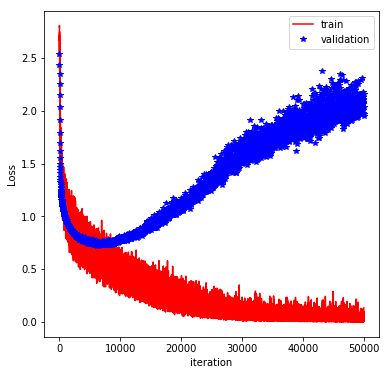

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

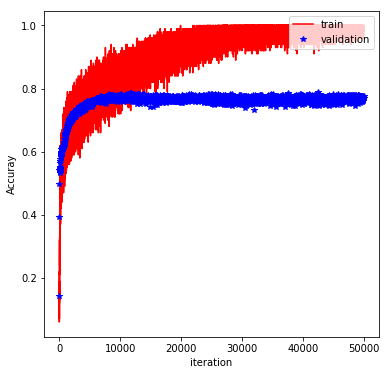

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
test_acc = []
test_loss = []
test_pred = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t, x_t_f, x_t_p in get_batches(X_test, y_test, X_test_feats, X_test_p, 157):
        feed = {inputs_: x_t,
                labels_: y_t,
                inputs2_: x_t_f,
                inputs3_: x_t_p,
                keep_prob_: 1}
        
        batch_loss, batch_acc = sess.run([cost, accuracy], feed_dict=feed)
        test_acc.append(batch_acc)
        test_loss.append(batch_loss)
        
        predict=tf.argmax(logits,1)
        best = predict.eval(feed_dict=feed)
        test_pred.append(best)
    
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    print("Test loss: {:.6f}".format(np.mean(test_loss)))
    
    oof_preds = np.concatenate(test_pred, axis=0)

INFO:tensorflow:Restoring parameters from checkpoints-cnn\har.ckpt
Test accuracy: 0.775159
Test loss: 1.891576


In [16]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

[ 9  2  2 ... 13  2 11]
[ 9  2  2 ... 13  2 11]
Normalized confusion matrix
[[0.83333333 0.         0.03333333 0.03333333 0.         0.
  0.03333333 0.         0.06666667 0.         0.         0.
  0.         0.        ]
 [0.         0.68686869 0.         0.06060606 0.         0.
  0.01010101 0.02020202 0.         0.         0.         0.22222222
  0.         0.        ]
 [0.         0.         0.97297297 0.         0.         0.
  0.         0.         0.00540541 0.         0.         0.
  0.02162162 0.        ]
 [0.         0.0209205  0.         0.60251046 0.0125523  0.
  0.10460251 0.0041841  0.         0.0167364  0.0041841  0.21757322
  0.         0.0167364 ]
 [0.         0.02777778 0.         0.33333333 0.13888889 0.
  0.13888889 0.         0.         0.         0.         0.36111111
  0.         0.        ]
 [0.16666667 0.         0.         0.         0.         0.83333333
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.0206185

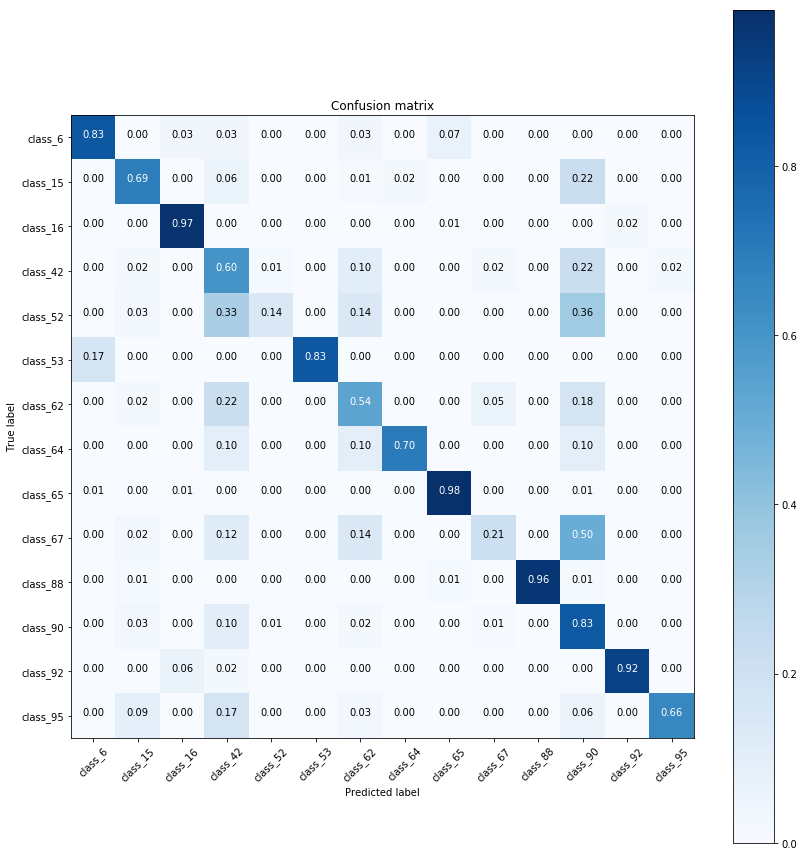

In [17]:
print(np.asarray(labels_test))

print(oof_preds+1)

cnf_matrix = confusion_matrix(np.asarray(labels_test), oof_preds+1)
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')